# 📓 Gemini Multimodal Supervised Fine‑Tuning — *RecipeBuilder*

**Last generated:** 2025-09-28 01:42 UTC

This notebook prepares a multimodal supervised fine‑tuning dataset from your Google Drive folders and Google Sheet,
then tunes a Gemini model on Vertex AI to predict **volume (cm³)** and **weight (g)** from an **image + label + width/height (inches)**.

It follows a cookbook style similar to your `RecipeBuilder_FT_Cookbook_SEPARATED`:
- Clearly labeled sections
- Run‑All friendly with a single configuration cell
- Rich inline comments & sanity checks
- JSONL dataset generation for *image tuning*
- Vertex AI SFT (Supervised Fine‑Tuning) job creation & polling
- Inference helpers for the tuned model

> **Important folder notes you mentioned**
> - Your class folders live under: `https://drive.google.com/drive/u/0/folders/1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn` (referred here as **IMAGES_DRIVE_ROOT_ID**).
> - Inside each class (e.g., `Apple/ apple_1`), **images live in** a `*.tensorflow/train/` folder .
> - Your spreadsheet: `https://docs.google.com/spreadsheets/d/1A-kOYpyKQchIti6jTjT_1TrdxIAw2Pb5ozFg9TibL-8/edit?gid=1081451428#gid=1081451428`
>   - First column `main` → labels (`apple`, `banana`, `avocado`, ...)
>   - Second column `directory` → e.g. `apple_1`
>   - Third column `subimage` → filename (e.g. `0_jpg.rf....jpg`)
>   - Columns **I** and **J** contain **width_in** and **height_in** (inches).

> **What the model learns**
> We *don't* provide density as an input; instead, the tuned model will implicitly learn density from label patterns.
> Targets are computed with simple shape heuristics + a tunable density lookup (you can edit it in one place).

> **Tip**
> Run this in **Colab** or **Vertex AI Workbench**. Make sure your GCP project has Vertex AI enabled and you have a GCS bucket.


## 0) 🔧 One‑cell configuration (edit and Run)

Set your project, region, bucket, and how to find your data. If you know the *mounted* Drive path to
`1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn`, set `DATASET_LOCAL_ROOT` (fast, no Drive API).
Otherwise, leave it `None` and the code will traverse by **names** under the Drive mount using a robust glob.


In [ ]:
# Drive root for SweetPotato dataset
DRIVE_SWEETPOTATO_FOLDER_ID = "1fHCChDQP8rwfn1XlAjuWqy4CASHaiF6b"


In [ ]:
from google.colab import userdata
try:
    from google.colab import userdata
    get_secret = userdata.get
except Exception:
    import os
    get_secret = os.getenv

#@title ✅ Project & data config
PROJECT_ID = get_secret("GOOGLE_CLOUD_PROJECT")
REGION     = get_secret("GOOGLE_DEFAULT_REGION") or "us-central1"
BUCKET_URI = get_secret("GOOGLE_DEFAULT_BUCKET")

# Normalize BUCKET_URI (allow bucket name or gs://bucket)
if BUCKET_URI and not BUCKET_URI.startswith("gs://"):
    BUCKET_URI = f"gs://{BUCKET_URI}"

# ---------- New SweetPotato inputs ----------
# Google Sheet with Item-based measurements (all images in an item share same values)
SHEET_URL = "https://docs.google.com/spreadsheets/d/1_vepmHiEM9NBh3X0n6gA4ZXk3MoVItFRqCCOoyW_sj4/edit?usp=drive_link"  #@param {type:"string"}
SHEET_GID = None  #@param {type:"number"}  # leave None to use the first tab

# Root Drive folder that contains numeric subfolders 1..100 (each has an `images/` subfolder)
DRIVE_SWEETPOTATO_FOLDER_ID = "1fHCChDQP8rwfn1XlAjuWqy4CASHaiF6b"  #@param {type:"string"}

# ---------- (unchanged) Base model and tuning knobs ----------
BASE_MODEL = "gemini-2.5-flash"  # e.g., "gemini-2.5-flash" or "gemini-2.5-pro"
EPOCH_COUNT = 2                  # int
LEARNING_RATE_MULTIPLIER = 1.0   # float
ADAPTER_SIZE = 4                 # int (allowed: 1, 4, 8, 16, 32)

# Note: DENSITY/SHAPE_RULES from the original flow are not used in SweetPotato
# because targets (Volume, Weight) come directly from the Sheet per Item.

from datetime import datetime as _dt
TUNED_MODEL_DISPLAY_NAME = f"recipebuilder-sft-{_dt.now().strftime('%Y%m%d-%H%M%S')}"

# --------- quick sanity prints ---------
print("✔ Config loaded.")
print("PROJECT_ID:", PROJECT_ID)
print("REGION:", REGION)
print("BUCKET_URI:", BUCKET_URI)
print("SHEET_URL:", SHEET_URL, "gid:", SHEET_GID)
print("DRIVE_SWEETPOTATO_FOLDER_ID:", DRIVE_SWEETPOTATO_FOLDER_ID)


✔ Config loaded.
PROJECT_ID: recipebuilder-473405
REGION: us-central1
BUCKET_URI: gs://recipebuilder-finetune
SHEET_URL: https://docs.google.com/spreadsheets/d/1_vepmHiEM9NBh3X0n6gA4ZXk3MoVItFRqCCOoyW_sj4/edit?usp=drive_link gid: None
DRIVE_SWEETPOTATO_FOLDER_ID: 1fHCChDQP8rwfn1XlAjuWqy4CASHaiF6b


## 1) 🧰 Install libraries

In [ ]:
#@title Install (Colab/Workbench)
!pip -q install --upgrade google-cloud-aiplatform google-genai gcsfs google-cloud-storage \
  pandas openpyxl gspread oauth2client pydrive2 tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


## 2) 🔐 Authenticate & init Vertex AI

In [ ]:
#@title Auth (Colab): Google account + Vertex init — robust
import os, re, math, json, hashlib, pathlib, glob, random, time, textwrap
from datetime import datetime
from typing import Dict, Any, Tuple

# 1) Colab account auth (no-op outside Colab)
try:
    from google.colab import auth as colab_auth
    colab_auth.authenticate_user()
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# 2) Helper to re-read secrets/env in case config cell wasn't executed yet
try:
    from google.colab import userdata
    _get = userdata.get
except Exception:
    _get = os.getenv

def _norm(s):
    if s is None:
        return ""
    return str(s).strip().strip('"').strip("'")

# Fill from globals or secrets/env; normalize and add gs:// if needed
def ensure_project_region_bucket():
    global PROJECT_ID, REGION, BUCKET_URI
    PROJECT_ID = _norm(globals().get("PROJECT_ID")) or _norm(_get("GOOGLE_CLOUD_PROJECT"))
    REGION     = _norm(globals().get("REGION"))     or _norm(_get("GOOGLE_DEFAULT_REGION")) or "us-central1"
    BUCKET_URI = _norm(globals().get("BUCKET_URI")) or _norm(_get("GOOGLE_DEFAULT_BUCKET"))
    if BUCKET_URI and not BUCKET_URI.startswith("gs://"):
        BUCKET_URI = f"gs://{BUCKET_URI}"

ensure_project_region_bucket()

# 3) Validate with clear guidance
def _fail(msg):
    raise AssertionError(
        msg +
        f"\n\nCurrent values:\n  PROJECT_ID={repr(globals().get('PROJECT_ID'))}\n"
        f"  REGION={repr(globals().get('REGION'))}\n"
        f"  BUCKET_URI={repr(globals().get('BUCKET_URI'))}\n"
        "How to fix:\n"
        "- In Colab: set 🔑 Variables GOOGLE_CLOUD_PROJECT, GOOGLE_DEFAULT_REGION, GOOGLE_DEFAULT_BUCKET.\n"
        "- Or export env vars before running: GOOGLE_CLOUD_PROJECT / GOOGLE_DEFAULT_REGION / GOOGLE_DEFAULT_BUCKET.\n"
        "- Bucket may be 'my-bucket' or 'gs://my-bucket'."
    )

if not PROJECT_ID:
    _fail("PROJECT_ID is empty.")
if not REGION:
    _fail("REGION is empty.")
if not BUCKET_URI or not BUCKET_URI.startswith("gs://"):
    _fail("BUCKET_URI is empty or missing 'gs://' prefix.")

print("Project:", PROJECT_ID)
print("Region :", REGION)
print("Bucket :", BUCKET_URI)

# 4) Init Vertex AI and ensure bucket exists
import vertexai
from google.cloud import storage

vertexai.init(project=PROJECT_ID, location=REGION)
print("✔ Vertex AI initialized.")

bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]
storage_client = storage.Client(project=PROJECT_ID)

try:
    buckets = [b.name for b in storage_client.list_buckets()]
    if bucket_name not in buckets:
        print(f"Creating bucket {BUCKET_URI} in {REGION} ...")
        # If gcloud isn't available/authorized, this will print guidance.
        exit_code = os.system(
            f"gcloud storage buckets create {BUCKET_URI} "
            f"--project {PROJECT_ID} --location={REGION} --uniform-bucket-level-access"
        )
        if exit_code != 0:
            print("⚠️ Could not auto-create bucket via gcloud. Create it once from console or run the command above manually.")
    else:
        print("✔ Bucket exists:", bucket_name)
except Exception as e:
    print("⚠️ Bucket check/create skipped due to:", e)

# 5) Mount Drive (if in Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    print("✔ Drive mounted at /content/drive")


Project: recipebuilder-473405
Region : us-central1
Bucket : gs://recipebuilder-finetune
✔ Vertex AI initialized.
✔ Bucket exists: recipebuilder-finetune
Mounted at /content/drive
✔ Drive mounted at /content/drive


## 3) 📑 Load spreadsheet → canonical DataFrame

We normalize column names to:
- `main` (label), `directory`, `subimage`, `width_in`, `height_in`

If your sheet uses different headers, the mapping below will try to auto‑detect.


In [ ]:
#@title Read + Normalize (compact) — SweetPotato (robust URL parsing + fallback)
import os, re, io, json, urllib.parse, requests, google.auth
import pandas as pd
from googleapiclient.discovery import build
from google.auth.transport.requests import Request

# ==== Inputs expected from config ====
# SHEET_URL  (string URL)   OR   SHEET_ID (bare id)
# SHEET_GID  (int or None)
def _norm(s):
    if s is None: return ""
    return str(s).strip().strip('"').strip("'")

SHEET_URL  = _norm(globals().get("SHEET_URL"))
SHEET_ID   = _norm(globals().get("SHEET_ID"))      # optional escape hatch
SHEET_GID  = 1038751137  # <— use your real gid here

# -------- helpers --------
def _parse_sheet_id_and_gid(url: str):
    """Extract spreadsheetId, resourcekey, gid (str) from many Google link forms."""
    if not url:
        return None
    url = url.strip()
    m = re.search(r"https?://docs\.google\.com/spreadsheets/(?:u/\d+/)?d/([-\w]+)", url)
    if m:
        sid = m.group(1)
        qs = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
        gid = (qs.get("gid") or [None])[0]
        rkey = (qs.get("resourcekey") or [None])[0]
        return {"id": sid, "gid": gid, "resourcekey": rkey}
    m = re.search(r"https?://drive\.google\.com/(?:u/\d+/)?file/d/([-\w]+)", url)
    if m:
        sid = m.group(1)
        qs = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
        gid = (qs.get("gid") or [None])[0]
        rkey = (qs.get("resourcekey") or [None])[0]
        return {"id": sid, "gid": gid, "resourcekey": rkey}
    qs = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
    if "id" in qs and qs["id"]:
        sid = qs["id"][0]
        gid = (qs.get("gid") or [None])[0]
        rkey = (qs.get("resourcekey") or [None])[0]
        return {"id": sid, "gid": gid, "resourcekey": rkey}
    return None

def _get_creds(scopes):
    c, _ = google.auth.default(scopes=scopes)
    if not c.valid:
        c.refresh(Request())
    return c

def _csv_export(spreadsheet_id: str, gid_str: str|None, resourcekey: str|None, token: str) -> bytes:
    gid = gid_str if gid_str is not None else "0"
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid}"
    if resourcekey:
        url += f"&resourcekey={urllib.parse.quote(resourcekey)}"
    r = requests.get(url, headers={"Authorization": f"Bearer {token}"}, timeout=60)
    r.raise_for_status()
    return r.content

def _sheets_api_df(spreadsheet_id: str, gid_str: str|None):
    creds = _get_creds([
        "https://www.googleapis.com/auth/spreadsheets.readonly",
        "https://www.googleapis.com/auth/drive.readonly",
    ])
    svc = build("sheets", "v4", credentials=creds, cache_discovery=False)
    meta = svc.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
    sheets = meta.get("sheets", [])
    title = None
    if gid_str is not None:
        for s in sheets:
            if str(s.get("properties", {}).get("sheetId")) == str(gid_str):
                title = s.get("properties", {}).get("title")
                break
    if not title:
        title = sheets[0].get("properties", {}).get("title", "Sheet1")
    rng = f"'{title}'"
    vals = svc.spreadsheets().values().get(spreadsheetId=spreadsheets_id, range=rng).execute().get("values", [])
    if not vals:
        raise ValueError("Sheets API returned no values.")
    headers, rows = vals[0], vals[1:]
    return pd.DataFrame(rows, columns=headers)

# -------- resolve spreadsheet id / gid --------
parsed = _parse_sheet_id_and_gid(SHEET_URL) if SHEET_URL else None
spreadsheet_id = None
gid_from_url   = None
resourcekey    = None

if parsed:
    spreadsheet_id = parsed["id"]
    gid_from_url   = parsed["gid"]
    resourcekey    = parsed["resourcekey"]

if not spreadsheet_id and SHEET_ID:
    spreadsheet_id = SHEET_ID  # allow direct id if URL is weird / blank

if not spreadsheet_id:
    raise ValueError("Could not determine spreadsheetId. Set SHEET_URL or SHEET_ID.")

gid_effective = str(int(SHEET_GID))  # <— force your known gid
print("Using spreadsheetId:", spreadsheet_id)
print("Using gid:", gid_effective, "| resourcekey:", resourcekey or "(none)")

# -------- load → DataFrame --------
creds = _get_creds([
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
])

try:
    blob = _csv_export(spreadsheet_id, gid_effective, resourcekey, creds.token)
    raw_df = pd.read_csv(io.BytesIO(blob))
    print("✔ Loaded via CSV export")
except Exception as e:
    print("CSV export failed → Sheets API fallback:", e)
    raw_df = _sheets_api_df(spreadsheet_id, gid_effective)
    print("✔ Loaded via Sheets API")

# ---- map columns for SweetPotato ----
def _canon(s): return re.sub(r"[ \t_\-\(\)]+","",str(s).strip().lower())

def pick(df_cols, *cands):
    C = {_canon(c) for c in cands}
    for col in df_cols:
        if _canon(col) in C:
            return col
    raise KeyError(f"Need one of {cands}; have {list(df_cols)}")

col_item   = pick(raw_df.columns, "item")
col_width  = pick(raw_df.columns, "width","width(inches)","width_in","w_in")
col_height = pick(raw_df.columns, "height","height(inches)","height_in","h_in")
col_wg     = pick(raw_df.columns, "weight(g)","weightg","weight","mass(g)")
col_vol    = pick(raw_df.columns, "volume(cm3)","volumecm3","volume")

df = (
    raw_df.rename(columns={
        col_item: "item",
        col_width: "width_in",
        col_height: "height_in",
        col_wg: "weight_g",
        col_vol: "volume_cm3",
    })[["item","width_in","height_in","weight_g","volume_cm3"]]
    .assign(
        item=lambda d: d.item.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
        weight_g=lambda d: pd.to_numeric(d.weight_g, errors="coerce"),
        volume_cm3=lambda d: pd.to_numeric(d.volume_cm3, errors="coerce"),
    )
    .dropna(subset=["item"])
    .drop_duplicates(subset=["item"])
    .reset_index(drop=True)
)

print("✔ columns mapped ->", {
    "Item": col_item,
    "width": col_width,
    "height": col_height,
    "Weight (g)": col_wg,
    "Volume (cm3)": col_vol
})
print(f"✔ items in sheet: {len(df)} (unique)")
na_cols = ["width_in","height_in","weight_g","volume_cm3"]
if df[na_cols].isna().any().any():
    miss = {c: int(df[c].isna().sum()) for c in na_cols if df[c].isna().any()}
    if miss:
        print("⚠️ Missing numeric values:", miss)

df.head()


Using spreadsheetId: 1_vepmHiEM9NBh3X0n6gA4ZXk3MoVItFRqCCOoyW_sj4
Using gid: 1038751137 | resourcekey: (none)
✔ Loaded via CSV export
✔ columns mapped -> {'Item': 'Item', 'width': 'width', 'height': 'height', 'Weight (g)': 'Weight (g)', 'Volume (cm3)': 'Volume (cm3)'}
✔ items in sheet: 100 (unique)


,item,width_in,height_in,weight_g,volume_cm3
0,1,19.0,5.0,230,250
1,2,13.0,8.0,236,240
2,3,12.0,7.5,248,260
3,4,12.5,7.0,224,205
4,5,13.0,6.5,212,180


## 4) 📂 Resolve image file paths on Drive

---



We look for files at: `DATASET_LOCAL_ROOT / main / directory / *tensorflow* / train / subimage`

If `DATASET_LOCAL_ROOT` is `None`, we search under your mounted Drive for matching paths.


In [ ]:
#@title Read sheet → Normalize → Resolve from Drive (SweetPotato) → Resize(50%) → Upload to GCS (all-in-one) — with progress + heartbeat
import os, io, re, hashlib, urllib.parse, json, time
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import List, Tuple

# ------------- Logging / controls -------------
VERBOSE = True           # print heartbeats
LOG_EVERY = 50           # print a line every N images
LIMIT_ITEMS = None       # e.g. 3   (None = all)
LIMIT_IMAGES_PER_ITEM = None  # e.g. 20 (None = all)
MAX_RETRIES = 5
BACKOFF_BASE = 1.0

# ---------- Config (uses existing globals if present) ----------
SHEET_URL  = globals().get("SHEET_URL")
SHEET_ID   = globals().get("SHEET_ID", None)
SHEET_GID  = globals().get("SHEET_GID", None)  # set to 1038751137 if you want to force a specific tab
DRIVE_SWEETPOTATO_FOLDER_ID = globals().get("DRIVE_SWEETPOTATO_FOLDER_ID")
PROJECT_ID = globals().get("PROJECT_ID")
BUCKET_URI = globals().get("BUCKET_URI")
TUNED_MODEL_DISPLAY_NAME = globals().get("TUNED_MODEL_DISPLAY_NAME", f"recipebuilder-sft-{datetime.utcnow().strftime('%Y%m%d-%H%M%S')}")

assert DRIVE_SWEETPOTATO_FOLDER_ID, "DRIVE_SWEETPOTATO_FOLDER_ID is not set."
assert PROJECT_ID and BUCKET_URI and BUCKET_URI.startswith("gs://"), "PROJECT_ID/BUCKET_URI not set."
bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]

# ---------- 1) Auth ----------
import google.auth, requests
from google.auth.transport.requests import Request
creds,_ = google.auth.default(scopes=[
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
    "https://www.googleapis.com/auth/cloud-platform",
])
if not creds.valid: creds.refresh(Request())

# ---------- 2) Sheet load (CSV → Sheets API fallback) ----------
from googleapiclient.discovery import build
sheets_svc = build("sheets", "v4", credentials=creds, cache_discovery=False)

def _parse_sheet_id_and_gid(url: str):
    if not url: return None
    m = re.search(r"https?://docs\.google\.com/spreadsheets/(?:u/\d+/)?d/([-\w]+)", url.strip())
    if not m:
        qs = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
        sid = (qs.get("id") or [None])[0]
        if sid:
            return {"id": sid, "gid": (qs.get("gid") or [None])[0], "resourcekey": (qs.get("resourcekey") or [None])[0]}
        return None
    sid = m.group(1)
    qs = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
    return {"id": sid, "gid": (qs.get("gid") or [None])[0], "resourcekey": (qs.get("resourcekey") or [None])[0]}

parsed = _parse_sheet_id_and_gid(SHEET_URL) if SHEET_URL else None
spreadsheet_id = SHEET_ID or (parsed["id"] if parsed else None)
assert spreadsheet_id, "Could not determine spreadsheetId. Set SHEET_URL or SHEET_ID."

gid_effective = str(int(SHEET_GID)) if SHEET_GID is not None else (parsed["gid"] if parsed and parsed["gid"] is not None else "0")

def _csv_export(spreadsheet_id: str, gid_str: str, resourcekey: str|None, token: str) -> bytes:
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={gid_str}"
    if resourcekey:
        url += f"&resourcekey={urllib.parse.quote(resourcekey)}"
    r = requests.get(url, headers={"Authorization": f"Bearer {token}"}, timeout=60)
    r.raise_for_status()
    return r.content

def _sheets_api_df(spreadsheet_id: str, gid_str: str|None):
    meta = sheets_svc.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
    sheets = meta.get("sheets", [])
    title = None
    if gid_str is not None:
        for s in sheets:
            if str(s.get("properties", {}).get("sheetId")) == str(gid_str):
                title = s.get("properties", {}).get("title"); break
    if not title:
        title = sheets[0].get("properties", {}).get("title", "Sheet1")
    rng = f"'{title}'"
    vals = sheets_svc.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=rng).execute().get("values", [])
    if not vals: raise ValueError("Sheets API returned no values.")
    return pd.DataFrame(vals[1:], columns=vals[0])

try:
    blob = _csv_export(spreadsheet_id, gid_effective, (parsed or {}).get("resourcekey"), creds.token)
    raw_df = pd.read_csv(io.BytesIO(blob))
    print("✔ Sheet loaded via CSV export")
except Exception as e:
    print("CSV export failed → Sheets API fallback:", e)
    raw_df = _sheets_api_df(spreadsheet_id, gid_effective)
    print("✔ Sheet loaded via Sheets API")

# Normalize headers → canonical df (one row per Item)
def _canon(s): return re.sub(r"[ \t_\-\(\)]+","",str(s).strip().lower())
def _pick(cols, *cands):
    C = {_canon(c) for c in cands}
    for col in cols:
        if _canon(col) in C: return col
    raise KeyError(f"Need one of {cands}; have {list(cols)}")

col_item   = _pick(raw_df.columns, "item")
col_width  = _pick(raw_df.columns, "width","width(inches)","width_in","w_in")
col_height = _pick(raw_df.columns, "height","height(inches)","height_in","h_in")
col_wg     = _pick(raw_df.columns, "weight(g)","weightg","weight","mass(g)")
col_vol    = _pick(raw_df.columns, "volume(cm3)","volumecm3","volume")

df = (
    raw_df.rename(columns={
        col_item:"item", col_width:"width_in", col_height:"height_in", col_wg:"weight_g", col_vol:"volume_cm3"
    })[["item","width_in","height_in","weight_g","volume_cm3"]]
    .assign(
        item=lambda d: d.item.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
        weight_g=lambda d: pd.to_numeric(d.weight_g, errors="coerce"),
        volume_cm3=lambda d: pd.to_numeric(d.volume_cm3, errors="coerce"),
    )
    .dropna(subset=["item"])
    .drop_duplicates(subset=["item"])
    .reset_index(drop=True)
)
print(f"✔ Normalized items: {len(df)}")

# ---------- 3) Drive crawl under DRIVE_SWEETPOTATO_FOLDER_ID ----------
from googleapiclient.discovery import build as build_drive
from googleapiclient.http import MediaIoBaseDownload
drive = build_drive("drive", "v3", credentials=creds, cache_discovery=False)
FOLDER_MIME = "application/vnd.google-apps.folder"
NUMERIC_ITEM_RE = re.compile(r"^\d{1,3}$")
IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp"}

def list_children(pid):
    q = f"'{pid}' in parents and trashed=false"
    page = None
    while True:
        resp = drive.files().list(
            q=q, pageSize=1000, pageToken=page,
            fields="nextPageToken,files(id,name,mimeType)",
            supportsAllDrives=True, includeItemsFromAllDrives=True
        ).execute()
        for f in resp.get("files", []):
            yield f
        page = resp.get("nextPageToken")
        if not page: break

root_children = [f for f in list_children(DRIVE_SWEETPOTATO_FOLDER_ID)]
item_folders = [
    f for f in root_children
    if f.get("mimeType")==FOLDER_MIME and NUMERIC_ITEM_RE.match(f.get("name",""))
]
item_folders = sorted(item_folders, key=lambda f: int(f["name"]))
if LIMIT_ITEMS:
    item_folders = item_folders[:int(LIMIT_ITEMS)]
print(f"✔ Item folders discovered: {len(item_folders)} (limit_items={LIMIT_ITEMS})")

# ---------- 4) Resize(50%) and upload to GCS (with heartbeat + retries) ----------
from google.cloud import storage
from PIL import Image

storage_client = storage.Client(project=PROJECT_ID)

def _gcs_parts(gs_uri: str):
    path = gs_uri[len("gs://"):]
    b, _, p = path.partition("/")
    return b, p

def blob_exists(gs_path: str) -> bool:
    b, p = _gcs_parts(gs_path)
    return storage_client.bucket(b).blob(p).exists()

def upload_bytes_to_gcs(gs_path: str, data: bytes, content_type: str):
    b, p = _gcs_parts(gs_path)
    blob = storage_client.bucket(b).blob(p)
    backoff = BACKOFF_BASE
    for attempt in range(1, MAX_RETRIES+1):
        try:
            blob.upload_from_string(data, content_type=content_type)
            return
        except Exception as e:
            if attempt == MAX_RETRIES: raise
            time.sleep(backoff); backoff *= 2

def download_drive_file(file_id: str) -> bytes:
    backoff = BACKOFF_BASE
    for attempt in range(1, MAX_RETRIES+1):
        try:
            req = drive.files().get_media(fileId=file_id, supportsAllDrives=True)
            fh = io.BytesIO()
            dl = MediaIoBaseDownload(fh, req)
            done = False
            while not done:
                _, done = dl.next_chunk()
            return fh.getvalue()
        except Exception:
            if attempt == MAX_RETRIES: raise
            time.sleep(backoff); backoff *= 2

def _sha10(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:10]

RUN = TUNED_MODEL_DISPLAY_NAME
resized_prefix = f"{RUN}/data_resized/images"

rows = []
total = 0
pbar_items = tqdm(item_folders, desc="Items", leave=True)

for item_folder in pbar_items:
    item = item_folder["name"]
    kids = list_children(item_folder["id"])
    img_dirs = [k for k in kids if k.get("mimeType")==FOLDER_MIME and k.get("name","").lower()=="images"]
    parent_id = img_dirs[0]["id"] if img_dirs else item_folder["id"]

    images = [f for f in list_children(parent_id)
              if f.get("mimeType") != FOLDER_MIME and os.path.splitext(f.get("name",""))[1].lower() in IMAGE_EXTS]
    if LIMIT_IMAGES_PER_ITEM:
        images = images[:int(LIMIT_IMAGES_PER_ITEM)]

    # pbar_imgs = tqdm(images, desc=f"Images (item {item})", leave=False)
    processed = 0
    for f in pbar_imgs:
        nm = f.get("name","")
        drive_file_id = f["id"]
        h = _sha10(drive_file_id + nm)
        target_gs = f"{BUCKET_URI}/{resized_prefix}/{h}_{nm}"

        if not blob_exists(target_gs):
            raw = download_drive_file(drive_file_id)
            img = Image.open(io.BytesIO(raw)).convert("RGB")
            w, h0 = img.size
            new_w, new_h = max(1, w//2), max(1, h0//2)
            img_resized = img.resize((new_w, new_h), Image.LANCZOS)
            out = io.BytesIO()
            img_resized.save(out, format="JPEG", quality=90)
            upload_bytes_to_gcs(target_gs, out.getvalue(), content_type="image/jpeg")

        rows.append({"item": item, "basename": nm, "drive_file_id": drive_file_id, "gcs_uri_resized": target_gs})
        total += 1; processed += 1
        if VERBOSE and total % LOG_EVERY == 0:
            print(f"[{datetime.utcnow().strftime('%H:%M:%S')}] processed {total} images…", flush=True)

    pbar_items.set_postfix_str(f"item={item}, +{processed} imgs")

df_imgs = pd.DataFrame(rows).drop_duplicates(subset=["item","basename"]).reset_index(drop=True)
print(f"\n☁️ Uploaded/linked resized images: {len(df_imgs)} (items={len(item_folders)}, total_seen={total}, limits: items={LIMIT_ITEMS}, imgs/item={LIMIT_IMAGES_PER_ITEM})")

# ---------- 5) Merge measurements onto images (by item) ----------
sft_df = (
    df_imgs.merge(df, on="item", how="inner")
           .sort_values(["item","basename"])
           .reset_index(drop=True)
)

missing_items = sorted(set(df_imgs["item"]) - set(df["item"]))
if missing_items:
    print("⚠️ Items with images but no measurements in sheet:", missing_items[:10], "..." if len(missing_items)>10 else "")

print("✔ SFT rows (images with targets):", len(sft_df))
display(sft_df.head(3))


/tmp/ipython-input-19755171.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  TUNED_MODEL_DISPLAY_NAME = globals().get("TUNED_MODEL_DISPLAY_NAME", f"recipebuilder-sft-{datetime.utcnow().strftime('%Y%m%d-%H%M%S')}")


✔ Sheet loaded via CSV export
✔ Normalized items: 100
✔ Item folders discovered: 100 (limit_items=None)


Items:   0%|          | 0/100 [00:00<?, ?it/s]

[18:45:56] processed 50 images…


/tmp/ipython-input-19755171.py:241: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().strftime('%H:%M:%S')}] processed {total} images…", flush=True)


[18:45:59] processed 100 images…
[18:46:03] processed 150 images…


Items:   1%|          | 1/100 [00:14<24:19, 14.74s/it, item=1, +179 imgs]

[18:46:07] processed 200 images…
[18:46:10] processed 250 images…
[18:46:13] processed 300 images…
[18:46:16] processed 350 images…


Items:   2%|▏         | 2/100 [00:26<21:14, 13.01s/it, item=2, +179 imgs]

[18:46:19] processed 400 images…
[18:46:22] processed 450 images…
[18:46:26] processed 500 images…


Items:   3%|▎         | 3/100 [00:38<20:03, 12.40s/it, item=3, +179 imgs]

[18:46:29] processed 550 images…
[18:46:32] processed 600 images…
[18:46:35] processed 650 images…
[18:46:39] processed 700 images…


Items:   4%|▍         | 4/100 [00:49<19:19, 12.08s/it, item=4, +179 imgs]

[18:46:42] processed 750 images…
[18:46:45] processed 800 images…
[18:46:48] processed 850 images…


Items:   5%|▌         | 5/100 [01:01<18:53, 11.93s/it, item=5, +179 imgs]

[18:46:52] processed 900 images…
[18:46:55] processed 950 images…
[18:46:58] processed 1000 images…
[18:47:01] processed 1050 images…


Items:   6%|▌         | 6/100 [01:13<18:30, 11.81s/it, item=6, +179 imgs]

[18:47:05] processed 1100 images…
[18:47:08] processed 1150 images…
[18:47:11] processed 1200 images…
[18:47:14] processed 1250 images…


Items:   7%|▋         | 7/100 [01:24<18:09, 11.72s/it, item=7, +179 imgs]

[18:47:18] processed 1300 images…
[18:47:21] processed 1350 images…
[18:47:24] processed 1400 images…


Items:   8%|▊         | 8/100 [01:36<17:58, 11.72s/it, item=8, +179 imgs]

[18:47:28] processed 1450 images…
[18:47:31] processed 1500 images…
[18:47:34] processed 1550 images…
[18:47:37] processed 1600 images…


Items:   9%|▉         | 9/100 [01:48<17:46, 11.72s/it, item=9, +179 imgs]

[18:47:41] processed 1650 images…
[18:47:44] processed 1700 images…
[18:47:47] processed 1750 images…


Items:  10%|█         | 10/100 [01:59<17:37, 11.75s/it, item=10, +179 imgs]

[18:47:51] processed 1800 images…
[18:47:54] processed 1850 images…
[18:47:57] processed 1900 images…
[18:48:00] processed 1950 images…


Items:  11%|█         | 11/100 [02:11<17:22, 11.71s/it, item=11, +179 imgs]

[18:48:04] processed 2000 images…
[18:48:07] processed 2050 images…
[18:48:10] processed 2100 images…


Items:  12%|█▏        | 12/100 [02:23<17:09, 11.70s/it, item=12, +179 imgs]

[18:48:14] processed 2150 images…
[18:48:17] processed 2200 images…
[18:48:20] processed 2250 images…
[18:48:23] processed 2300 images…


Items:  13%|█▎        | 13/100 [02:34<16:49, 11.60s/it, item=13, +179 imgs]

[18:48:26] processed 2350 images…
[18:48:30] processed 2400 images…
[18:48:33] processed 2450 images…
[18:48:36] processed 2500 images…


Items:  14%|█▍        | 14/100 [02:46<16:53, 11.79s/it, item=14, +179 imgs]

[18:48:40] processed 2550 images…
[18:48:43] processed 2600 images…
[18:48:46] processed 2650 images…


Items:  15%|█▌        | 15/100 [02:58<16:35, 11.71s/it, item=15, +179 imgs]

[18:48:50] processed 2700 images…
[18:48:52] processed 2750 images…
[18:48:55] processed 2800 images…
[18:48:58] processed 2850 images…


Items:  16%|█▌        | 16/100 [03:09<16:15, 11.62s/it, item=16, +179 imgs]

[18:49:02] processed 2900 images…
[18:49:05] processed 2950 images…
[18:49:08] processed 3000 images…


Items:  17%|█▋        | 17/100 [03:21<16:01, 11.59s/it, item=17, +179 imgs]

[18:49:12] processed 3050 images…
[18:49:15] processed 3100 images…
[18:49:18] processed 3150 images…
[18:49:21] processed 3200 images…


Items:  18%|█▊        | 18/100 [03:32<15:52, 11.62s/it, item=18, +179 imgs]

[18:49:25] processed 3250 images…
[18:49:28] processed 3300 images…
[18:49:31] processed 3350 images…
[18:49:34] processed 3400 images…


Items:  19%|█▉        | 19/100 [03:44<15:38, 11.59s/it, item=19, +179 imgs]

[18:49:38] processed 3450 images…
[18:49:41] processed 3500 images…
[18:49:44] processed 3550 images…


Items:  20%|██        | 20/100 [03:55<15:25, 11.57s/it, item=20, +179 imgs]

[18:49:47] processed 3600 images…
[18:49:50] processed 3650 images…
[18:49:53] processed 3700 images…
[18:49:56] processed 3750 images…


Items:  21%|██        | 21/100 [04:07<15:10, 11.53s/it, item=21, +179 imgs]

[18:50:00] processed 3800 images…
[18:50:03] processed 3850 images…
[18:50:06] processed 3900 images…


Items:  22%|██▏       | 22/100 [04:18<15:01, 11.56s/it, item=22, +179 imgs]

[18:50:10] processed 3950 images…
[18:50:13] processed 4000 images…
[18:50:16] processed 4050 images…
[18:50:19] processed 4100 images…


Items:  23%|██▎       | 23/100 [04:30<14:54, 11.62s/it, item=23, +179 imgs]

[18:50:24] processed 4150 images…
[18:50:27] processed 4200 images…
[18:50:30] processed 4250 images…


Items:  24%|██▍       | 24/100 [04:43<15:05, 11.91s/it, item=24, +179 imgs]

[18:50:34] processed 4300 images…
[18:50:37] processed 4350 images…
[18:50:40] processed 4400 images…
[18:50:43] processed 4450 images…


Items:  25%|██▌       | 25/100 [04:55<14:55, 11.94s/it, item=25, +179 imgs]

[18:50:47] processed 4500 images…
[18:50:50] processed 4550 images…
[18:50:53] processed 4600 images…
[18:50:56] processed 4650 images…


Items:  26%|██▌       | 26/100 [05:06<14:32, 11.79s/it, item=26, +179 imgs]

[18:51:00] processed 4700 images…
[18:51:03] processed 4750 images…
[18:51:06] processed 4800 images…


Items:  27%|██▋       | 27/100 [05:18<14:13, 11.69s/it, item=27, +179 imgs]

[18:51:10] processed 4850 images…
[18:51:13] processed 4900 images…
[18:51:16] processed 4950 images…
[18:51:19] processed 5000 images…


Items:  28%|██▊       | 28/100 [05:29<13:58, 11.64s/it, item=28, +179 imgs]

[18:51:23] processed 5050 images…
[18:51:26] processed 5100 images…
[18:51:29] processed 5150 images…


Items:  29%|██▉       | 29/100 [05:41<13:51, 11.71s/it, item=29, +179 imgs]

[18:51:33] processed 5200 images…
[18:51:36] processed 5250 images…
[18:51:39] processed 5300 images…
[18:51:42] processed 5350 images…


Items:  30%|███       | 30/100 [05:53<13:35, 11.65s/it, item=30, +179 imgs]

[18:51:45] processed 5400 images…
[18:51:48] processed 5450 images…
[18:51:51] processed 5500 images…


Items:  31%|███       | 31/100 [06:04<13:21, 11.62s/it, item=31, +179 imgs]

[18:51:55] processed 5550 images…
[18:51:58] processed 5600 images…
[18:52:01] processed 5650 images…
[18:52:04] processed 5700 images…


Items:  32%|███▏      | 32/100 [06:16<13:10, 11.63s/it, item=32, +179 imgs]

[18:52:08] processed 5750 images…
[18:52:11] processed 5800 images…
[18:52:14] processed 5850 images…
[18:52:17] processed 5900 images…


Items:  33%|███▎      | 33/100 [06:28<13:01, 11.67s/it, item=33, +179 imgs]

[18:52:24] processed 5950 images…
[18:52:27] processed 6000 images…
[18:52:30] processed 6050 images…


Items:  34%|███▍      | 34/100 [06:42<13:53, 12.63s/it, item=34, +179 imgs]

[18:52:34] processed 6100 images…
[18:52:37] processed 6150 images…
[18:52:40] processed 6200 images…
[18:52:43] processed 6250 images…


Items:  35%|███▌      | 35/100 [06:54<13:20, 12.32s/it, item=35, +179 imgs]

[18:52:47] processed 6300 images…
[18:52:50] processed 6350 images…
[18:52:53] processed 6400 images…


Items:  36%|███▌      | 36/100 [07:06<12:58, 12.17s/it, item=36, +179 imgs]

[18:52:57] processed 6450 images…
[18:53:00] processed 6500 images…
[18:53:03] processed 6550 images…
[18:53:06] processed 6600 images…


Items:  37%|███▋      | 37/100 [07:17<12:31, 11.93s/it, item=37, +179 imgs]

[18:53:10] processed 6650 images…
[18:53:13] processed 6700 images…
[18:53:16] processed 6750 images…
[18:53:19] processed 6800 images…


Items:  38%|███▊      | 38/100 [07:29<12:09, 11.77s/it, item=38, +179 imgs]

[18:53:22] processed 6850 images…
[18:53:25] processed 6900 images…
[18:53:28] processed 6950 images…


Items:  39%|███▉      | 39/100 [07:40<11:53, 11.69s/it, item=39, +179 imgs]

[18:53:32] processed 7000 images…
[18:53:35] processed 7050 images…
[18:53:38] processed 7100 images…
[18:53:41] processed 7150 images…


Items:  40%|████      | 40/100 [07:52<11:38, 11.64s/it, item=40, +179 imgs]

[18:53:45] processed 7200 images…
[18:53:48] processed 7250 images…
[18:53:51] processed 7300 images…


Items:  41%|████      | 41/100 [08:03<11:28, 11.67s/it, item=41, +179 imgs]

[18:53:55] processed 7350 images…
[18:53:58] processed 7400 images…
[18:54:01] processed 7450 images…
[18:54:04] processed 7500 images…


Items:  42%|████▏     | 42/100 [08:15<11:18, 11.70s/it, item=42, +179 imgs]

[18:54:08] processed 7550 images…
[18:54:11] processed 7600 images…
[18:54:14] processed 7650 images…


Items:  43%|████▎     | 43/100 [08:27<11:10, 11.77s/it, item=43, +179 imgs]

[18:54:18] processed 7700 images…
[18:54:21] processed 7750 images…
[18:54:24] processed 7800 images…
[18:54:27] processed 7850 images…


Items:  44%|████▍     | 44/100 [08:38<10:52, 11.65s/it, item=44, +179 imgs]

[18:54:31] processed 7900 images…
[18:54:34] processed 7950 images…
[18:54:37] processed 8000 images…
[18:54:40] processed 8050 images…


Items:  45%|████▌     | 45/100 [08:50<10:41, 11.66s/it, item=45, +179 imgs]

[18:54:44] processed 8100 images…
[18:54:47] processed 8150 images…
[18:54:50] processed 8200 images…


Items:  46%|████▌     | 46/100 [09:02<10:25, 11.58s/it, item=46, +179 imgs]

[18:54:54] processed 8250 images…
[18:54:57] processed 8300 images…
[18:55:00] processed 8350 images…
[18:55:03] processed 8400 images…


Items:  47%|████▋     | 47/100 [09:13<10:17, 11.65s/it, item=47, +179 imgs]

[18:55:07] processed 8450 images…
[18:55:10] processed 8500 images…
[18:55:12] processed 8550 images…


Items:  48%|████▊     | 48/100 [09:25<10:03, 11.60s/it, item=48, +179 imgs]

[18:55:16] processed 8600 images…
[18:55:19] processed 8650 images…
[18:55:22] processed 8700 images…
[18:55:25] processed 8750 images…


Items:  49%|████▉     | 49/100 [09:37<09:53, 11.64s/it, item=49, +179 imgs]

[18:55:29] processed 8800 images…
[18:55:32] processed 8850 images…
[18:55:35] processed 8900 images…
[18:55:38] processed 8950 images…


Items:  50%|█████     | 50/100 [09:48<09:39, 11.59s/it, item=50, +179 imgs]

[18:55:46] processed 9000 images…
[18:55:49] processed 9050 images…
[18:55:52] processed 9100 images…


Items:  51%|█████     | 51/100 [10:03<10:23, 12.72s/it, item=51, +179 imgs]

[18:55:58] processed 9150 images…
[18:56:01] processed 9200 images…
[18:56:04] processed 9250 images…
[18:56:07] processed 9300 images…


Items:  52%|█████▏    | 52/100 [10:18<10:34, 13.21s/it, item=52, +179 imgs]

[18:56:11] processed 9350 images…
[18:56:15] processed 9400 images…
[18:56:18] processed 9450 images…


Items:  53%|█████▎    | 53/100 [10:30<10:01, 12.79s/it, item=53, +179 imgs]

[18:56:21] processed 9500 images…
[18:56:24] processed 9550 images…
[18:56:27] processed 9600 images…
[18:56:30] processed 9650 images…


Items:  54%|█████▍    | 54/100 [10:41<09:30, 12.40s/it, item=54, +179 imgs]

[18:56:34] processed 9700 images…
[18:56:37] processed 9750 images…
[18:56:40] processed 9800 images…


Items:  55%|█████▌    | 55/100 [10:53<09:12, 12.27s/it, item=55, +179 imgs]

[18:56:44] processed 9850 images…
[18:56:47] processed 9900 images…
[18:56:51] processed 9950 images…
[18:56:54] processed 10000 images…


Items:  56%|█████▌    | 56/100 [11:05<08:56, 12.18s/it, item=56, +179 imgs]

[18:56:58] processed 10050 images…
[18:57:01] processed 10100 images…
[18:57:04] processed 10150 images…
[18:57:07] processed 10200 images…


Items:  57%|█████▋    | 57/100 [11:17<08:41, 12.12s/it, item=57, +179 imgs]

[18:57:11] processed 10250 images…
[18:57:14] processed 10300 images…
[18:57:17] processed 10350 images…


Items:  58%|█████▊    | 58/100 [11:29<08:21, 11.94s/it, item=58, +179 imgs]

[18:57:21] processed 10400 images…
[18:57:24] processed 10450 images…
[18:57:27] processed 10500 images…
[18:57:30] processed 10550 images…


Items:  59%|█████▉    | 59/100 [11:40<08:08, 11.92s/it, item=59, +179 imgs]

[18:57:34] processed 10600 images…
[18:57:37] processed 10650 images…
[18:57:40] processed 10700 images…


Items:  60%|██████    | 60/100 [11:52<07:51, 11.80s/it, item=60, +179 imgs]

[18:57:43] processed 10750 images…
[18:57:46] processed 10800 images…
[18:57:49] processed 10850 images…
[18:57:52] processed 10900 images…


Items:  61%|██████    | 61/100 [12:03<07:36, 11.72s/it, item=61, +179 imgs]

[18:57:56] processed 10950 images…
[18:57:59] processed 11000 images…
[18:58:02] processed 11050 images…


Items:  62%|██████▏   | 62/100 [12:15<07:19, 11.57s/it, item=62, +179 imgs]

[18:58:06] processed 11100 images…
[18:58:09] processed 11150 images…
[18:58:12] processed 11200 images…
[18:58:15] processed 11250 images…


Items:  63%|██████▎   | 63/100 [12:27<07:11, 11.66s/it, item=63, +179 imgs]

[18:58:19] processed 11300 images…
[18:58:22] processed 11350 images…
[18:58:25] processed 11400 images…
[18:58:28] processed 11450 images…


Items:  64%|██████▍   | 64/100 [12:38<07:00, 11.68s/it, item=64, +179 imgs]

[18:58:32] processed 11500 images…
[18:58:35] processed 11550 images…
[18:58:38] processed 11600 images…


Items:  65%|██████▌   | 65/100 [12:50<06:46, 11.61s/it, item=65, +179 imgs]

[18:58:41] processed 11650 images…
[18:58:44] processed 11700 images…
[18:58:47] processed 11750 images…
[18:58:50] processed 11800 images…


Items:  66%|██████▌   | 66/100 [13:01<06:32, 11.54s/it, item=66, +179 imgs]

[18:58:54] processed 11850 images…
[18:58:57] processed 11900 images…
[18:59:00] processed 11950 images…


Items:  67%|██████▋   | 67/100 [13:12<06:16, 11.41s/it, item=67, +179 imgs]

[18:59:03] processed 12000 images…
[18:59:06] processed 12050 images…
[18:59:09] processed 12100 images…
[18:59:12] processed 12150 images…


Items:  68%|██████▊   | 68/100 [13:23<06:03, 11.36s/it, item=68, +179 imgs]

[18:59:16] processed 12200 images…
[18:59:19] processed 12250 images…
[18:59:22] processed 12300 images…
[18:59:25] processed 12350 images…


Items:  69%|██████▉   | 69/100 [13:35<05:53, 11.39s/it, item=69, +179 imgs]

[18:59:29] processed 12400 images…
[18:59:32] processed 12450 images…
[18:59:35] processed 12500 images…


Items:  70%|███████   | 70/100 [13:46<05:40, 11.36s/it, item=70, +179 imgs]

[18:59:38] processed 12550 images…
[18:59:41] processed 12600 images…
[18:59:44] processed 12650 images…
[18:59:47] processed 12700 images…


Items:  71%|███████   | 71/100 [13:58<05:29, 11.37s/it, item=71, +179 imgs]

[18:59:51] processed 12750 images…
[18:59:54] processed 12800 images…
[18:59:57] processed 12850 images…


Items:  72%|███████▏  | 72/100 [14:09<05:19, 11.39s/it, item=72, +179 imgs]

[19:00:01] processed 12900 images…
[19:00:04] processed 12950 images…
[19:00:07] processed 13000 images…
[19:00:10] processed 13050 images…


Items:  73%|███████▎  | 73/100 [14:21<05:09, 11.46s/it, item=73, +179 imgs]

[19:00:13] processed 13100 images…
[19:00:16] processed 13150 images…
[19:00:19] processed 13200 images…


Items:  74%|███████▍  | 74/100 [14:32<04:57, 11.46s/it, item=74, +179 imgs]

[19:00:23] processed 13250 images…
[19:00:26] processed 13300 images…
[19:00:29] processed 13350 images…
[19:00:32] processed 13400 images…


Items:  75%|███████▌  | 75/100 [14:43<04:45, 11.42s/it, item=75, +179 imgs]

[19:00:36] processed 13450 images…
[19:00:39] processed 13500 images…
[19:00:42] processed 13550 images…
[19:00:45] processed 13600 images…


Items:  76%|███████▌  | 76/100 [14:55<04:35, 11.49s/it, item=76, +179 imgs]

[19:00:49] processed 13650 images…
[19:00:52] processed 13700 images…
[19:00:55] processed 13750 images…


Items:  77%|███████▋  | 77/100 [15:07<04:25, 11.55s/it, item=77, +179 imgs]

[19:00:59] processed 13800 images…
[19:01:02] processed 13850 images…
[19:01:05] processed 13900 images…
[19:01:08] processed 13950 images…


Items:  78%|███████▊  | 78/100 [15:18<04:14, 11.57s/it, item=78, +179 imgs]

[19:01:12] processed 14000 images…
[19:01:15] processed 14050 images…
[19:01:18] processed 14100 images…


Items:  79%|███████▉  | 79/100 [15:30<04:02, 11.55s/it, item=79, +179 imgs]

[19:01:21] processed 14150 images…
[19:01:24] processed 14200 images…
[19:01:27] processed 14250 images…
[19:01:30] processed 14300 images…


Items:  80%|████████  | 80/100 [15:42<03:51, 11.57s/it, item=80, +179 imgs]

[19:01:34] processed 14350 images…
[19:01:37] processed 14400 images…
[19:01:40] processed 14450 images…


Items:  81%|████████  | 81/100 [15:53<03:38, 11.51s/it, item=81, +179 imgs]

[19:01:44] processed 14500 images…
[19:01:47] processed 14550 images…
[19:01:50] processed 14600 images…
[19:01:53] processed 14650 images…


Items:  82%|████████▏ | 82/100 [16:04<03:27, 11.53s/it, item=82, +179 imgs]

[19:01:57] processed 14700 images…
[19:02:00] processed 14750 images…
[19:02:03] processed 14800 images…
[19:02:06] processed 14850 images…


Items:  83%|████████▎ | 83/100 [16:16<03:17, 11.60s/it, item=83, +179 imgs]

[19:02:10] processed 14900 images…
[19:02:13] processed 14950 images…
[19:02:16] processed 15000 images…


Items:  84%|████████▍ | 84/100 [16:28<03:05, 11.59s/it, item=84, +179 imgs]

[19:02:19] processed 15050 images…
[19:02:22] processed 15100 images…
[19:02:25] processed 15150 images…
[19:02:28] processed 15200 images…


Items:  85%|████████▌ | 85/100 [16:39<02:53, 11.54s/it, item=85, +179 imgs]

[19:02:32] processed 15250 images…
[19:02:35] processed 15300 images…
[19:02:38] processed 15350 images…


Items:  86%|████████▌ | 86/100 [16:51<02:40, 11.49s/it, item=86, +179 imgs]

[19:02:42] processed 15400 images…
[19:02:45] processed 15450 images…
[19:02:48] processed 15500 images…
[19:02:51] processed 15550 images…


Items:  87%|████████▋ | 87/100 [17:02<02:29, 11.48s/it, item=87, +179 imgs]

[19:02:54] processed 15600 images…
[19:02:57] processed 15650 images…
[19:03:00] processed 15700 images…
[19:03:03] processed 15750 images…


Items:  88%|████████▊ | 88/100 [17:13<02:17, 11.44s/it, item=88, +179 imgs]

[19:03:07] processed 15800 images…
[19:03:10] processed 15850 images…
[19:03:13] processed 15900 images…


Items:  89%|████████▉ | 89/100 [17:25<02:05, 11.39s/it, item=89, +179 imgs]

[19:03:17] processed 15950 images…
[19:03:20] processed 16000 images…
[19:03:23] processed 16050 images…
[19:03:26] processed 16100 images…


Items:  90%|█████████ | 90/100 [17:37<01:55, 11.56s/it, item=90, +179 imgs]

[19:03:30] processed 16150 images…
[19:03:33] processed 16200 images…
[19:03:36] processed 16250 images…


Items:  91%|█████████ | 91/100 [17:48<01:43, 11.53s/it, item=91, +179 imgs]

[19:03:40] processed 16300 images…
[19:03:43] processed 16350 images…
[19:03:46] processed 16400 images…
[19:03:49] processed 16450 images…


Items:  92%|█████████▏| 92/100 [18:00<01:32, 11.57s/it, item=92, +179 imgs]

[19:03:52] processed 16500 images…
[19:03:55] processed 16550 images…
[19:03:58] processed 16600 images…


Items:  93%|█████████▎| 93/100 [18:11<01:20, 11.53s/it, item=93, +179 imgs]

[19:04:02] processed 16650 images…
[19:04:05] processed 16700 images…
[19:04:08] processed 16750 images…
[19:04:11] processed 16800 images…


Items:  94%|█████████▍| 94/100 [18:23<01:08, 11.47s/it, item=94, +179 imgs]

[19:04:15] processed 16850 images…
[19:04:18] processed 16900 images…
[19:04:21] processed 16950 images…
[19:04:24] processed 17000 images…


Items:  95%|█████████▌| 95/100 [18:34<00:57, 11.44s/it, item=95, +179 imgs]

[19:04:27] processed 17050 images…
[19:04:30] processed 17100 images…
[19:04:33] processed 17150 images…


Items:  96%|█████████▌| 96/100 [18:45<00:45, 11.43s/it, item=96, +179 imgs]

[19:04:37] processed 17200 images…
[19:04:40] processed 17250 images…
[19:04:43] processed 17300 images…
[19:04:46] processed 17350 images…


Items:  97%|█████████▋| 97/100 [18:57<00:34, 11.46s/it, item=97, +179 imgs]

[19:04:50] processed 17400 images…
[19:04:53] processed 17450 images…
[19:04:56] processed 17500 images…


Items:  98%|█████████▊| 98/100 [19:08<00:22, 11.44s/it, item=98, +179 imgs]

[19:05:00] processed 17550 images…
[19:05:03] processed 17600 images…
[19:05:06] processed 17650 images…
[19:05:09] processed 17700 images…


Items:  99%|█████████▉| 99/100 [19:20<00:11, 11.50s/it, item=99, +179 imgs]

[19:05:12] processed 17750 images…
[19:05:15] processed 17800 images…
[19:05:18] processed 17850 images…
[19:05:22] processed 17900 images…


Items: 100%|██████████| 100/100 [19:31<00:00, 11.72s/it, item=100, +179 imgs]


☁️ Uploaded/linked resized images: 17900 (items=100, total_seen=17900, limits: items=None, imgs/item=None)
✔ SFT rows (images with targets): 17900


,item,basename,drive_file_id,gcs_uri_resized,width_in,height_in,weight_g,volume_cm3
0,1,img00001.png,1a8ZMqT7_nbAkuavrbO4-baHop5Zia1Un,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250
1,1,img00002.png,1Bn57dTPuDu3754kYrySniF-aLia-zFTh,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250
2,1,img00003.png,18QLpTS4MFUSq257HPeOdExO3cXZGy4Lj,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250


# 🔍 Audit & Fix Duplicates in GCS (by Drive ID & MD5)


In [ ]:
# Optional: audit md5 duplicates under RUN/data_resized/images (no deletes)
from google.cloud import storage
import pandas as pd, collections

assert BUCKET_URI.startswith("gs://")
bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]
RUN = TUNED_MODEL_DISPLAY_NAME
prefix = f"{RUN}/data_resized/images/"

client = storage.Client(project=PROJECT_ID)
blobs = list(client.bucket(bucket_name).list_blobs(prefix=prefix))

print(f"Scanned {len(blobs)} blobs under gs://{bucket_name}/{prefix}")
dupes = collections.defaultdict(list)
for b in blobs:
    if b.md5_hash:  # base64 md5
        dupes[b.md5_hash].append(b)

dupe_groups = {k:v for k,v in dupes.items() if len(v) > 1}
print(f"MD5-identical groups: {len(dupe_groups)}")
if dupe_groups:
    for i, (md5, group) in enumerate(list(dupe_groups.items())[:5], 1):
        print(f"{i}. {len(group)} copies → sample: {group[0].name}")

# (Optional) see if any sft_df URIs point to these duplicates
if "sft_df" in globals() and "gcs_uri_resized" in sft_df.columns:
    sft_paths = sft_df["gcs_uri_resized"].str.replace("gs://"+bucket_name+"/", "", regex=False)
    hits = []
    dupe_paths = {b.name for g in dupe_groups.values() for b in g}
    for p in sft_paths:
        if p in dupe_paths:
            hits.append(p)
    print(f"sft_df references within duplicate groups: {len(hits)}")


Scanned 390 blobs under gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/
MD5-identical groups: 3
1. 3 copies → sample: recipebuilder-sft-20251029-182246/data_resized/images/52f8f7b8bc_img00182.png
2. 3 copies → sample: recipebuilder-sft-20251029-182246/data_resized/images/67e670bd3b_img00158.png
3. 2 copies → sample: recipebuilder-sft-20251029-182246/data_resized/images/b090dc4f66_img00179.png
sft_df references within duplicate groups: 200


In [ ]:
print("RUN used in audit prefix:", RUN)
print("RUN printed after upload:", TUNED_MODEL_DISPLAY_NAME)

print("\nSample URIs from sft_df:")
print(sft_df["gcs_uri_resized"].head(3).tolist())

# Count how many sft_df rows point under the audit prefix
audit_prefix = f"gs://{bucket_name}/{RUN}/data_resized/images/"
print("\n# sft_df rows under audit prefix:",
      int(sft_df["gcs_uri_resized"].str.startswith(audit_prefix).sum()))


RUN used in audit prefix: recipebuilder-sft-20251029-182246
RUN printed after upload: recipebuilder-sft-20251029-182246

Sample URIs from sft_df:
['gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/03ca2a7c1a_img00001.png', 'gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/49f563e207_img00002.png', 'gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/dbd82bfdb5_img00003.png']

# sft_df rows under audit prefix: 17900


## 5) 🧮 Compute ground‑truth targets (volume, weight)

We convert inches → centimeters and apply shape heuristics:
- **Ellipsoid**: \(V = \frac{4}{3}\pi a b c\). With `a,b,c` derived from `width`/`height`.
- **Banana (cyl + 2 hemispheres)**: \(V = \pi r^2 (h + \tfrac{4}{3}r)\).

Then `weight_g = volume_cm3 * density[label]`.


In [ ]:
#@title 🎯 Use targets from sheet (Volume & Weight) — no shape math (SweetPotato, merge by item)
import pandas as pd, re

def _canon(s: str) -> str:
    return re.sub(r"[ \t_\-\(\)]+", "", str(s).strip().lower())

# 0) Preconditions
if "raw_df" not in globals():
    raise RuntimeError("raw_df is missing. Run the SweetPotato Read+Normalize cell first.")
if "df_imgs" not in globals() and "sft_df" not in globals():
    raise RuntimeError("df_imgs/sft_df is missing. Run the SweetPotato crawl→resize→upload cell first.")

# 1) Map columns from the SweetPotato sheet
lk = {_canon(c): c for c in raw_df.columns}
col_item   = lk.get("item")
col_width  = lk.get("width") or lk.get("width(inches)") or lk.get("widthin") or lk.get("width_in")
col_height = lk.get("height") or lk.get("height(inches)") or lk.get("heightin") or lk.get("height_in")
col_wg     = lk.get("weight(g)") or lk.get("weightg") or lk.get("weight") or lk.get("massg")
col_vol    = lk.get("volume(cm3)") or lk.get("volumecm3") or lk.get("volume")

req = [col_item, col_width, col_height, col_wg, col_vol]
assert all(req), f"Missing expected columns in sheet. Have: {list(raw_df.columns)}"

# 2) Build a clean per-item targets frame
meas = (
    raw_df.rename(columns={
        col_item: "item",
        col_width: "width_in",
        col_height: "height_in",
        col_wg: "weight_g",
        col_vol: "volume_cm3",
    })[["item","width_in","height_in","weight_g","volume_cm3"]]
    .assign(
        item=lambda d: d.item.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
        weight_g=lambda d: pd.to_numeric(d.weight_g, errors="coerce"),
        volume_cm3=lambda d: pd.to_numeric(d.volume_cm3, errors="coerce"),
    )
    .dropna(subset=["item"])
    .drop_duplicates(subset=["item"])
    .reset_index(drop=True)
)

# 3) Decide input rows to annotate (prefer sft_df if already built)
if "sft_df" in globals():
    base = sft_df.copy()
elif "df_imgs" in globals():
    # df_imgs has one row per image with columns: item, basename, gcs_uri_resized
    base = df_imgs.copy()
else:
    raise RuntimeError("No base DataFrame found to merge targets into.")

# 4) Merge targets by item (idempotent)
out = (
    base.drop(columns=[c for c in ["width_in","height_in","weight_g","volume_cm3"] if c in base.columns])
        .merge(meas, on="item", how="left")
        .sort_values(["item"] + ([ "basename" ] if "basename" in base.columns else []))
        .reset_index(drop=True)
)

# 5) Report
missing_v = int(out["volume_cm3"].isna().sum())
missing_w = int(out["weight_g"].isna().sum())
print(f"✔ Targets merged by item. Missing Volume: {missing_v}, Missing Weight: {missing_w}")
if missing_v or missing_w:
    print("⚠️ Some items in images have no targets in the sheet. Check item labels or sheet rows.")

# 6) Publish result back to sft_df for downstream cells
sft_df = out
try:
    from IPython.display import display
    display(sft_df.head(3))
except Exception:
    print(sft_df.head(3))


✔ Targets merged by item. Missing Volume: 0, Missing Weight: 0


,item,basename,drive_file_id,gcs_uri_resized,width_in,height_in,weight_g,volume_cm3
0,1,img00001.png,1a8ZMqT7_nbAkuavrbO4-baHop5Zia1Un,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250
1,1,img00002.png,1Bn57dTPuDu3754kYrySniF-aLia-zFTh,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250
2,1,img00003.png,18QLpTS4MFUSq257HPeOdExO3cXZGy4Lj,gs://recipebuilder-finetune/recipebuilder-sft-...,19.0,5.0,230,250


## 6) 📦 Build & Upload JSONL for Gemini SFT (uses gcs_uri + sheet targets)



In [ ]:
#@title 📦 Build & Upload JSONL for Gemini SFT — SweetPotato (use RESIZED URIs)
import os, json, random, re, textwrap
import pandas as pd
from datetime import datetime
from google.cloud import storage

# 0) Source = SweetPotato frame with resized URIs
assert 'sft_df' in globals(), "sft_df not found. Run the SweetPotato crawl→resize→merge-targets step first."
src = sft_df.copy()

# 1) Choose URI column: must be resized
assert "gcs_uri_resized" in src.columns and src["gcs_uri_resized"].notna().any(), \
    "Missing gcs_uri_resized. Ensure the SweetPotato all-in-one step created resized uploads."
src = src.assign(file_uri=src["gcs_uri_resized"])

# 2) Keep only usable rows (have URIs and targets)
need = ["item","width_in","height_in","volume_cm3","weight_g","file_uri"]
missing = [c for c in need if c not in src.columns]
assert not missing, f"Missing required columns: {missing}"

usable = (src[need]
          .dropna(subset=["file_uri","volume_cm3","weight_g","width_in","height_in"])
          .reset_index(drop=True))

# Optional: coerce numeric
for c in ["width_in","height_in","volume_cm3","weight_g"]:
    usable[c] = pd.to_numeric(usable[c], errors="coerce")

print({"total_rows": len(src), "usable_rows": len(usable)})

# 3) Shuffle + split (90/10)
TRAIN_VAL_SPLIT = 0.9
rows = usable.to_dict("records")
random.seed(42); random.shuffle(rows)
cut = int(TRAIN_VAL_SPLIT * len(rows))
train_rows, val_rows = rows[:cut], rows[cut:]

def _guess_mime(uri: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg": "image/jpeg",
        "jpeg": "image/jpeg",
        "png": "image/png",
        "webp": "image/webp",
        "bmp": "image/bmp",
        "tif": "image/tiff",
        "tiff": "image/tiff",
        "gif": "image/gif",
    }.get(ext, "image/jpeg")

def build_prompt(r):
    # Keep it short & consistent; you can add more context if you like
    return textwrap.dedent(f"""\
        Return JSON only with keys volume_cm3 and weight_g.
        Item: {r['item']} (SweetPotato)
        Width (in): {float(r['width_in']):.6f}
        Height (in): {float(r['height_in']):.6f}
    """).strip()

def to_example(r):
    target = {"volume_cm3": float(r["volume_cm3"]), "weight_g": float(r["weight_g"])}
    return {
        "contents": [
            {"role":"user","parts":[
                {"fileData":{"mimeType": _guess_mime(r["file_uri"]), "fileUri": r["file_uri"]}},
                {"text": build_prompt(r)}
            ]},
            {"role":"model","parts":[{"text": json.dumps(target, separators=(",",":"))}]}
        ]
    }

# 4) Write local JSONLs
out_dir = "/content/jsonl/sweetpotato_resized"
os.makedirs(out_dir, exist_ok=True)
train_fp = f"{out_dir}/train.jsonl"
val_fp   = f"{out_dir}/val.jsonl"

with open(train_fp, "w") as f:
    for r in train_rows: f.write(json.dumps(to_example(r))+"\n")
with open(val_fp, "w") as f:
    for r in val_rows: f.write(json.dumps(to_example(r))+"\n")

print("Train:", train_fp, "records:", len(train_rows))
print("Val  :", val_fp,   "records:", len(val_rows))

# 5) Upload under a fresh timestamped prefix
stamp = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
RUN = TUNED_MODEL_DISPLAY_NAME
DATASET_PREFIX = f"{RUN}/data_resized_{stamp}/all/jsonl"

client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET_URI.replace("gs://","").split("/",1)[0]
bucket = client.bucket(bucket_name)

train_blob = bucket.blob(f"{DATASET_PREFIX}/train.jsonl")
val_blob   = bucket.blob(f"{DATASET_PREFIX}/val.jsonl")
train_blob.upload_from_filename(train_fp)
val_blob.upload_from_filename(val_fp)

TRAIN_JSONL_URI = f"gs://{bucket_name}/{train_blob.name}"
VAL_JSONL_URI   = f"gs://{bucket_name}/{val_blob.name}"
print("✔ Train JSONL:", TRAIN_JSONL_URI)
print("✔ Val   JSONL:", VAL_JSONL_URI)

# 6) Quick audit: ensure we referenced /data_resized/ URIs
from google.cloud import storage as _st
def _audit(uri, n=3):
    b,p = uri.replace("gs://","").split("/",1)
    blob = _st.Client(project=PROJECT_ID).bucket(b).blob(p)
    lines = blob.download_as_text().splitlines()[:n]
    ok = True
    for i,l in enumerate(lines,1):
        ex = json.loads(l)
        u  = ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        print(f"[{i}] {u}")
        if "/data_resized/" not in u:
            ok = False
    print("✅ uses resized images" if ok else "❌ not resized")
    return ok

print("\nAudit train:"); _audit(TRAIN_JSONL_URI)
print("Audit val:");   _audit(VAL_JSONL_URI)


{'total_rows': 17900, 'usable_rows': 17900}
Train: /content/jsonl/sweetpotato_resized/train.jsonl records: 16110
Val  : /content/jsonl/sweetpotato_resized/val.jsonl records: 1790


/tmp/ipython-input-3368185473.py:88: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  stamp = datetime.utcnow().strftime("%Y%m%d-%H%M%S")


✔ Train JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/train.jsonl
✔ Val   JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl

Audit train:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/91e2bc17a2_img00119.png
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/7abca6cb6e_img00105.png
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/e2e637ffbd_img00065.png
✅ uses resized images
Audit val:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/1c36df0046_img00053.png
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/13ee2ff2e9_img00120.png
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/86b1852863_img00021.png
✅ uses resized images


True

In [ ]:
#@title 🔍 Verify half-dims (round), equal aspect ratio (tolerant), and file-size change (sample)
from google.cloud import storage
from googleapiclient.http import MediaIoBaseDownload
from PIL import Image
import io, pandas as pd, math, random

# Preconditions: SweetPotato pipeline artifacts
base = None
if "sft_df" in globals() and {"gcs_uri_resized","item","basename","width_in","height_in"}.issubset(sft_df.columns):
    base = sft_df.copy()
elif "df_imgs" in globals() and {"gcs_uri_resized","item","basename","drive_file_id"}.issubset(df_imgs.columns):
    base = df_imgs.copy()
else:
    raise RuntimeError("Need sft_df or df_imgs with columns: gcs_uri_resized, item, basename, (drive_file_id if using df_imgs).")

assert "drive" in globals(), "Drive client 'drive' not found. Run the SweetPotato crawl cell that creates it."
assert "PROJECT_ID" in globals() and "BUCKET_URI" in globals()
assert base["gcs_uri_resized"].notna().any(), "gcs_uri_resized missing."

# Ensure drive_file_id present (sft_df may not carry it depending on your merge)
if "drive_file_id" not in base.columns:
    # try to pull from df_imgs if available
    if "df_imgs" in globals():
        base = base.merge(df_imgs[["item","basename","drive_file_id"]], on=["item","basename"], how="left")
    assert base["drive_file_id"].notna().any(), "drive_file_id not found to fetch originals from Drive."

# --- helpers to read images from GCS / Drive ---
gcs = storage.Client(project=PROJECT_ID)

def _gcs_read_dims(uri: str):
    b,p = uri.replace("gs://","").split("/",1)
    blob = gcs.bucket(b).blob(p)
    data = blob.download_as_bytes()
    with Image.open(io.BytesIO(data)) as im:
        return im.width, im.height, len(data)

def _drive_read_dims(file_id: str):
    req = drive.files().get_media(fileId=file_id, supportsAllDrives=True)
    buf = io.BytesIO()
    dl = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    data = buf.getvalue()
    with Image.open(io.BytesIO(data)) as im:
        return im.width, im.height, len(data)

def _half_ok(w0,h0,w1,h1):
    # round(0.5 * w/h) with ±1 px tolerance
    tw, th = max(1, round(w0*0.5)), max(1, round(h0*0.5))
    return (abs(w1 - tw) <= 1) and (abs(h1 - th) <= 1)

def _aspect_ok(w0,h0,w1,h1, atol=1e-2):
    ar0 = w0 / max(1e-6, h0)
    ar1 = w1 / max(1e-6, h1)
    return math.isclose(ar0, ar1, rel_tol=0.0, abs_tol=atol)

# --- choose a small sample and verify ---
N = min(10, len(base))
sample = base.sample(N, random_state=7)

rows = []
missing_orig = 0

for _, r in sample.iterrows():
    try:
        # resized (GCS)
        w1,h1,b1 = _gcs_read_dims(r["gcs_uri_resized"])
        # original (Drive)
        w0,h0,b0 = _drive_read_dims(str(r["drive_file_id"]))
        rows.append({
            "item": r["item"],
            "basename": r["basename"],
            "orig_wh": (w0,h0),
            "resz_wh": (w1,h1),
            "half_dims": _half_ok(w0,h0,w1,h1),
            "same_aspect": _aspect_ok(w0,h0,w1,h1, atol=1e-2),
            "bytes_ratio": round(b1/max(1,b0), 3),
        })
    except Exception:
        missing_orig += 1

chk = pd.DataFrame(rows)
print(f"Sample size: {N}; verified: {len(chk)}; missing originals: {missing_orig}")
print("All half_dims OK?:", None if chk.empty else bool(chk["half_dims"].all()))
print("All same_aspect OK?:", None if chk.empty else bool(chk["same_aspect"].all()))
display(chk.head(N))


Sample size: 10; verified: 10; missing originals: 0
All half_dims OK?: True
All same_aspect OK?: True


,item,basename,orig_wh,resz_wh,half_dims,same_aspect,bytes_ratio
0,11,img00129.png,"(1280, 720)","(640, 360)",True,True,0.063
1,65,img00106.png,"(1280, 720)","(640, 360)",True,True,0.089
2,37,img00106.png,"(1280, 720)","(640, 360)",True,True,0.089
3,63,img00039.png,"(1280, 720)","(640, 360)",True,True,0.108
4,62,img00058.png,"(1280, 720)","(640, 360)",True,True,0.100
5,96,img00069.png,"(1280, 720)","(640, 360)",True,True,0.092
6,98,img00033.png,"(1280, 720)","(640, 360)",True,True,0.111
7,44,img00087.png,"(1280, 720)","(640, 360)",True,True,0.079
8,100,img00081.png,"(1280, 720)","(640, 360)",True,True,0.087
9,24,img00051.png,"(1280, 720)","(640, 360)",True,True,0.118


## 7) 🚀 Launch Supervised Fine‑Tuning (SFT)

We use the Vertex AI SDK `sft.train(...)`. This will create a tuning job and a tuned model.


In [ ]:
#@title ⚖️ Fast token estimate: sample + text-only (no images), robust logging
from vertexai import init as vertex_init
from vertexai.generative_models import GenerativeModel, Part, Content
from google.cloud import storage
import json, random, re

assert "TRAIN_JSONL_URI" in globals(), "TRAIN_JSONL_URI missing."
assert "BASE_MODEL" in globals(), "BASE_MODEL missing."
assert "EPOCH_COUNT" in globals(), "EPOCH_COUNT missing."
vertex_init(project=PROJECT_ID, location=REGION)

# Load jsonl
client = storage.Client(project=PROJECT_ID)
bkt, path = TRAIN_JSONL_URI.replace("gs://","").split("/", 1)
blob = client.bucket(bkt).blob(path)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines]
N = len(examples)
print(f"Loaded {N} training rows from {TRAIN_JSONL_URI}")

# Sample
SAMPLE_SIZE = min(200, N)   # speed vs accuracy
random.seed(7)
sample = random.sample(examples, SAMPLE_SIZE) if N > SAMPLE_SIZE else examples

model = GenerativeModel(BASE_MODEL)

def _to_text_only_contents(ex):
    """Keep only user text parts; skip image fileData for counting."""
    user = ex["contents"][0]
    parts = []
    for p in user.get("parts", []):
        if isinstance(p, dict) and "text" in p:
            parts.append(Part.from_text(p["text"]))
    # Fallback if somehow no text parts exist
    if not parts:
        parts.append(Part.from_text(""))
    return [Content(role="user", parts=parts)]

# Count tokens for sample (text-only)
sample_tokens = 0
ok = 0
for i, ex in enumerate(sample, 1):
    try:
        result = model.count_tokens(_to_text_only_contents(ex))
        sample_tokens += result.total_tokens
        ok += 1
        if i % 50 == 0 or i == len(sample):
            print(f"[counted {i}/{len(sample)}] running avg ≈ {sample_tokens/max(1, ok):.1f} tokens/ex")
    except Exception as e:
        # Skip malformed rows rather than failing entire estimate
        print(f"⚠️ count_tokens failed on sample #{i}: {e}")

avg_tokens = sample_tokens / max(1, ok)
per_epoch_tokens_est = int(avg_tokens * N)
all_epochs_tokens_est = per_epoch_tokens_est * int(EPOCH_COUNT)

price_per_million = 5.0  # adjust if your SFT pricing differs
print("\n— Estimation —")
print(f"Rows: {N}")
print(f"Avg tokens/example (text-only est): {avg_tokens:.1f} (from {ok}/{len(sample)} samples)")
print(f"Tokens (1 epoch, est): {per_epoch_tokens_est:,}")
print(f"Tokens (all epochs={EPOCH_COUNT}, est): {all_epochs_tokens_est:,}")
print(f"Est. cost (1 epoch): ${(per_epoch_tokens_est/1_000_000)*price_per_million:.2f}")
print("Note: images skipped for speed; this slightly underestimates true SFT cost.")


Loaded 16110 training rows from gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/train.jsonl
[counted 50/200] running avg ≈ 53.3 tokens/ex
[counted 100/200] running avg ≈ 53.4 tokens/ex
[counted 150/200] running avg ≈ 53.4 tokens/ex
[counted 200/200] running avg ≈ 53.4 tokens/ex

— Estimation —
Rows: 16110
Avg tokens/example (text-only est): 53.4 (from 200/200 samples)
Tokens (1 epoch, est): 860,274
Tokens (all epochs=2, est): 1,720,548
Est. cost (1 epoch): $4.30
Note: images skipped for speed; this slightly underestimates true SFT cost.


In [ ]:
#@title 🚀 Start tuning job (resized guards + robust polling)
import time, json, math
from datetime import datetime, timezone
from vertexai.tuning import sft
from google.cloud import storage

# ---- Preconditions & guards ----
assert isinstance(ADAPTER_SIZE, int), f"ADAPTER_SIZE must be int, got {type(ADAPTER_SIZE)}"
assert ADAPTER_SIZE in (1, 4, 8, 16, 32), f"Unsupported ADAPTER_SIZE={ADAPTER_SIZE} (valid: 1,4,8,16,32)"
assert isinstance(EPOCH_COUNT, int) and EPOCH_COUNT >= 1, f"EPOCH_COUNT must be int >=1, got {EPOCH_COUNT}"
assert "TRAIN_JSONL_URI" in globals() and "VAL_JSONL_URI" in globals(), "Missing TRAIN_JSONL_URI/VAL_JSONL_URI"

# Accept either ".../data_resized/" or ".../data_resized_<stamp>/"
assert "data_resized" in TRAIN_JSONL_URI, f"TRAIN_JSONL_URI not resized-ish: {TRAIN_JSONL_URI}"
assert "data_resized" in VAL_JSONL_URI,   f"VAL_JSONL_URI not resized-ish: {VAL_JSONL_URI}"

def _audit_jsonl_uris(gs_uri, n=3):
    """Ensure the JSONL's fileUri parts reference /data_resized/ images."""
    b, p = gs_uri.replace("gs://","").split("/", 1)
    blob = storage.Client(project=PROJECT_ID).bucket(b).blob(p)
    lines = blob.download_as_text().splitlines()[:n]
    ok = True
    for i, line in enumerate(lines, 1):
        ex = json.loads(line)
        uri = ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        print(f"[{i}] {uri}")
        if "/data_resized/" not in uri:
            ok = False
    return ok

print("\nAudit TRAIN samples:")
ok_train = _audit_jsonl_uris(TRAIN_JSONL_URI, n=3)
print("Audit VAL samples:")
ok_val = _audit_jsonl_uris(VAL_JSONL_URI, n=3)
assert ok_train, "TRAIN JSONL contains non-resized fileUri(s)."
assert ok_val,   "VAL JSONL contains non-resized fileUri(s)."

print("\nBase model      :", BASE_MODEL)
print("Display name    :", TUNED_MODEL_DISPLAY_NAME)
print("Train JSONL     :", TRAIN_JSONL_URI)
print("Val JSONL       :", VAL_JSONL_URI)
print("Epochs          :", EPOCH_COUNT)
print("Adapter size    :", ADAPTER_SIZE)
print("LR multiplier   :", LEARNING_RATE_MULTIPLIER)

# ---- Launch SFT job ----
job = sft.train(
    source_model=BASE_MODEL,
    train_dataset=TRAIN_JSONL_URI,
    validation_dataset=VAL_JSONL_URI,
    tuned_model_display_name=TUNED_MODEL_DISPLAY_NAME,
    epochs=EPOCH_COUNT,
    adapter_size=ADAPTER_SIZE,
    learning_rate_multiplier=LEARNING_RATE_MULTIPLIER,
)

print("\nTuningJob:", job.resource_name)

# ---- Robust polling (elapsed, state changes, soft timeout) ----
poll_seconds = 30
soft_timeout_hours = 6  # adjust if needed
deadline = time.time() + soft_timeout_hours * 3600
last_state = None
start = datetime.now(timezone.utc)

print(f"Polling every {poll_seconds}s (soft timeout {soft_timeout_hours}h)…")
while True:
    job.refresh()
    if job.state != last_state:
        elapsed = (datetime.now(timezone.utc) - start).total_seconds()
        print(f"[{elapsed/60:.1f} min] state → {job.state}")
        last_state = job.state
    if job.has_ended:
        break
    if time.time() > deadline:
        print("⚠️ Soft timeout reached; job still running. You can re-run this cell later to resume polling.")
        break
    time.sleep(poll_seconds)

# ---- Final report ----
print("\nFinal state     :", job.state)
print("Tuned model name:", job.tuned_model_name)
print("Endpoint name   :", getattr(job, "tuned_model_endpoint_name", None))

# For inference later (SDK only; not Vertex Predict for Gemini)
TUNED_MODEL_NAME = job.tuned_model_name



Audit TRAIN samples:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/91e2bc17a2_img00119.png
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/7abca6cb6e_img00105.png
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/e2e637ffbd_img00065.png
Audit VAL samples:


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob


[1] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/1c36df0046_img00053.png
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/13ee2ff2e9_img00120.png
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/86b1852863_img00021.png

Base model      : gemini-2.5-flash
Display name    : recipebuilder-sft-20251029-182246
Train JSONL     : gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/train.jsonl
Val JSONL       : gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl
Epochs          : 2
Adapter size    : 4
LR multiplier   : 1.0


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/927828199877/locations/us-central1/tuningJobs/1664927734238806016
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/927828199877/locations/us-central1/tuningJobs/1664927734238806016')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/1664927734238806016?project=927828199877



TuningJob: projects/927828199877/locations/us-central1/tuningJobs/1664927734238806016
Polling every 30s (soft timeout 6h)…
[0.0 min] state → 3


[154.3 min] state → 4

Final state     : 4
Tuned model name: projects/927828199877/locations/us-central1/models/8949350649468813312@1
Endpoint name   : projects/927828199877/locations/us-central1/endpoints/1720417938609012736


In [ ]:
#@title 🔎 Discover previous JSONL datasets in GCS (RecipeBuilder runs)
from google.cloud import storage
import re, pandas as pd
from datetime import datetime

assert BUCKET_URI.startswith("gs://")
bucket_name = BUCKET_URI.replace("gs://","").split("/",1)[0]
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(bucket_name)

# Heuristics: look for typical SFT JSONL locations used in your notebooks
CANDIDATE_PREFIXES = [
    "",  # full bucket scan (filtered by regex below)
    f"{TUNED_MODEL_DISPLAY_NAME}/",  # current run
    "recipebuilder/",                 # your “new layout” root if used earlier
]

rows = []
rx = re.compile(r".*/jsonl/(train|val)\.jsonl$")
for pref in CANDIDATE_PREFIXES:
    for blob in client.list_blobs(bucket_name, prefix=pref):
        if rx.match(blob.name):
            rows.append({
                "path": blob.name,
                "size": blob.size,
                "updated": blob.updated,
                "has_resized": ("/data_resized/" in blob.name),
                "is_train": blob.name.endswith("/train.jsonl"),
                "is_val": blob.name.endswith("/val.jsonl"),
            })

df_prev = pd.DataFrame(rows).sort_values("updated", ascending=False).reset_index(drop=True)
print(f"Found {len(df_prev)} JSONL blobs in gs://{bucket_name}")
try:
    from IPython.display import display
    display(df_prev.head(20))
except Exception:
    print(df_prev.head(20))

# Optional: pick the most recent *pair* automatically
def pick_latest_pair(df):
    # find train that has a matching val (same directory)
    for _, r in df.sort_values("updated", ascending=False).iterrows():
        if not r["is_train"]:
            continue
        base_dir = r["path"].rsplit("/", 1)[0]
        val_path = base_dir + "/val.jsonl"
        if (df["path"] == val_path).any():
            return f"gs://{bucket_name}/{r['path']}", f"gs://{bucket_name}/{val_path}"
    return None, None

PREV_TRAIN_JSONL_URI, PREV_VAL_JSONL_URI = pick_latest_pair(df_prev)
print("\nAuto-pick latest pair:")
print("PREV_TRAIN_JSONL_URI:", PREV_TRAIN_JSONL_URI)
print("PREV_VAL_JSONL_URI  :", PREV_VAL_JSONL_URI)


Found 22 JSONL blobs in gs://recipebuilder-finetune


,path,size,updated,has_resized,is_train,is_val
0,recipebuilder-sft-20251029-182246/data_resized...,761765,2025-10-29 19:15:45.771000+00:00,False,False,True
1,recipebuilder-sft-20251029-182246/data_resized...,761765,2025-10-29 19:15:45.771000+00:00,False,False,True
2,recipebuilder-sft-20251029-182246/data_resized...,6856475,2025-10-29 19:15:45.485000+00:00,False,True,False
3,recipebuilder-sft-20251029-182246/data_resized...,6856475,2025-10-29 19:15:45.485000+00:00,False,True,False
4,recipebuilder-sft-20251005-213246/data_resized...,206071,2025-10-05 22:52:24.443000+00:00,False,False,True
5,recipebuilder-sft-20251005-213246/data_resized...,1852290,2025-10-05 22:52:24.240000+00:00,False,True,False
6,recipebuilder-sft-20251005-213246/data_resized...,9051,2025-10-05 22:49:32+00:00,False,False,True
7,recipebuilder-sft-20251005-213246/data_resized...,81439,2025-10-05 22:49:31.889000+00:00,False,True,False
8,recipebuilder-sft-20251003-214927/data_resized...,9130,2025-10-03 23:05:19.326000+00:00,False,False,True
9,recipebuilder-sft-20251003-214927/data_resized...,81710,2025-10-03 23:05:19.099000+00:00,False,True,False



Auto-pick latest pair:
PREV_TRAIN_JSONL_URI: gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/train.jsonl
PREV_VAL_JSONL_URI  : gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl


In [ ]:
#@title 🔎 Find legacy (non-SweetPotato) JSONLs in bucket and sample them
from google.cloud import storage
import re, json, datetime as dt
import pandas as pd

assert BUCKET_URI.startswith("gs://")
bkt = BUCKET_URI.replace("gs://","").split("/",1)[0]
client = storage.Client(project=PROJECT_ID)

# 1) List all JSONL blobs under the bucket
blobs = []
for b in client.list_blobs(bkt):
    if b.name.lower().endswith(".jsonl"):
        blobs.append(b)

def _sample_kind(uri:str, max_lines=8):
    """Return ('sweetpotato'|'legacy'|'unknown', first_line_text, first_file_uri)."""
    b, p = uri.replace("gs://","").split("/",1)
    text = client.bucket(b).blob(p).download_as_text()
    first = None
    file_uri = None
    kind = "unknown"
    for i, line in enumerate(text.splitlines()):
        if i >= max_lines: break
        try:
            ex = json.loads(line)
            parts = ex["contents"][0]["parts"]
            t = next((pp.get("text") for pp in parts if "text" in pp), "")
            f = next((pp["fileData"]["fileUri"] for pp in parts if "fileData" in pp), "")
            if first is None:
                first, file_uri = t, f
            tl = (t or "").lower()
            if "sweetpotato" in tl or tl.startswith("item:") or tl.startswith("item "):
                kind = "sweetpotato"
                break
            # heuristics for your legacy set
            if "label:" in tl or any(k in tl for k in ["apple","banana","avocado"]):
                kind = "legacy"
                break
        except Exception:
            continue
    return kind, (first or ""), (file_uri or "")

# 2) Group train/val by prefix
def _pair_key(name:str):
    # expect .../jsonl/train.jsonl or val.jsonl -> take parent dir as key
    m = re.match(r"(.+?/jsonl/)(train|val)\.jsonl$", name)
    return m.group(1) if m else None

rows = []
for b in blobs:
    key = _pair_key(b.name)
    if not key:
        continue
    uri = f"gs://{bkt}/{b.name}"
    kind, preview_text, preview_fileuri = _sample_kind(uri)
    rows.append({
        "prefix": key,
        "name": b.name,
        "uri": uri,
        "updated": b.updated,
        "size": b.size,
        "is_train": b.name.endswith("/train.jsonl"),
        "is_val":   b.name.endswith("/val.jsonl"),
        "kind": kind,
        "preview_text": preview_text[:120],
        "preview_fileuri": preview_fileuri
    })

dfj = pd.DataFrame(rows).sort_values("updated", ascending=False).reset_index(drop=True)
print(f"Found {len(dfj)} JSONLs grouped into {dfj['prefix'].nunique()} prefixes")

# 3) Show top candidates by kind
def show(kind):
    sub = dfj[dfj["kind"]==kind].copy()
    if sub.empty:
        print(f"\n(no {kind} JSONLs found)")
        return None
    # ensure we have both train & val in the prefix
    pairs = (sub.groupby("prefix")
                .filter(lambda g: g["is_train"].any() and g["is_val"].any())
                .sort_values("updated", ascending=False))
    if pairs.empty:
        print(f"\n({kind}: found files, but not complete train/val pairs)")
        return None
    print(f"\nTop {kind} candidates:")
    display(pairs.head(6)[["updated","uri","is_train","is_val","preview_text"]])
    # pick latest complete pair
    latest_prefix = pairs.iloc[0]["prefix"]
    train_uri = pairs[(pairs["prefix"]==latest_prefix) & (pairs["is_train"])].iloc[0]["uri"]
    val_uri   = pairs[(pairs["prefix"]==latest_prefix) & (pairs["is_val"])].iloc[0]["uri"]
    return train_uri, val_uri

LEGACY_PICK = show("legacy")
SP_PICK     = show("sweetpotato")

if LEGACY_PICK:
    LEGACY_TRAIN_JSONL_URI, LEGACY_VAL_JSONL_URI = LEGACY_PICK
    print("\n✔ Latest LEGACY pair:")
    print("LEGACY_TRAIN_JSONL_URI =", LEGACY_TRAIN_JSONL_URI)
    print("LEGACY_VAL_JSONL_URI   =", LEGACY_VAL_JSONL_URI)

if SP_PICK:
    SP_TRAIN_CANDIDATE_URI, SP_VAL_CANDIDATE_URI = SP_PICK
    print("\n(i) Latest SweetPotato pair (if you want to reuse full set instead of 1–5):")
    print("SP_TRAIN_CANDIDATE_URI =", SP_TRAIN_CANDIDATE_URI)
    print("SP_VAL_CANDIDATE_URI   =", SP_VAL_CANDIDATE_URI)


Found 20 JSONLs grouped into 10 prefixes

Top legacy candidates:


,updated,uri,is_train,is_val,preview_text
2,2025-10-05 22:52:24.443000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,False,True,Return JSON only with keys volume_cm3 and weig...
3,2025-10-05 22:52:24.240000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,True,False,Return JSON only with keys volume_cm3 and weig...
4,2025-10-05 22:49:32+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,False,True,Return JSON only with keys volume_cm3 and weig...
5,2025-10-05 22:49:31.889000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,True,False,Return JSON only with keys volume_cm3 and weig...
6,2025-10-03 23:05:19.326000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,False,True,Return JSON only with keys volume_cm3 and weig...
7,2025-10-03 23:05:19.099000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,True,False,Return JSON only with keys volume_cm3 and weig...



Top sweetpotato candidates:


,updated,uri,is_train,is_val,preview_text
0,2025-10-29 19:15:45.771000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,False,True,Return JSON only with keys volume_cm3 and weig...
1,2025-10-29 19:15:45.485000+00:00,gs://recipebuilder-finetune/recipebuilder-sft-...,True,False,Return JSON only with keys volume_cm3 and weig...



✔ Latest LEGACY pair:
LEGACY_TRAIN_JSONL_URI = gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/train.jsonl
LEGACY_VAL_JSONL_URI   = gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl

(i) Latest SweetPotato pair (if you want to reuse full set instead of 1–5):
SP_TRAIN_CANDIDATE_URI = gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/train.jsonl
SP_VAL_CANDIDATE_URI   = gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl


In [ ]:
#@title 🧪 Merge: Legacy + SweetPotato (items 1–5 only) → new train/val JSONLs
from google.cloud import storage
import json, re, random, os
from datetime import datetime

# ---- Inputs discovered earlier (edit if needed)
assert 'LEGACY_TRAIN_JSONL_URI' in globals() and 'LEGACY_VAL_JSONL_URI' in globals(), "Run the discovery cell to set LEGACY_*."
assert 'SP_TRAIN_CANDIDATE_URI' in globals() and 'SP_VAL_CANDIDATE_URI' in globals(), "Run the discovery cell to set SP_*."

LEGACY_TRAIN = LEGACY_TRAIN_JSONL_URI
LEGACY_VAL   = LEGACY_VAL_JSONL_URI
SP_TRAIN     = SP_TRAIN_CANDIDATE_URI
SP_VAL       = SP_VAL_CANDIDATE_URI

# Include only these SweetPotato items
ITEMS_TO_INCLUDE = {"1","2","3","4","5"}  # change if you want a different subset

# ---- Helpers
def _read_jsonl_gs(gs_uri: str):
    bkt, path = gs_uri.replace("gs://","").split("/", 1)
    cl = storage.Client(project=PROJECT_ID)
    blob = cl.bucket(bkt).blob(path)
    lines = blob.download_as_text().splitlines()
    out = []
    for l in lines:
        try:
            out.append(json.loads(l))
        except Exception:
            pass
    return out

def _extract_item_and_label(ex):
    """Return (item_str_or_None, label_or_None) from the user text."""
    try:
        parts = ex["contents"][0]["parts"]
        txt = next((p.get("text","") for p in parts if "text" in p), "")
        # SweetPotato format examples:
        #   "Item: 93 (SweetPotato)\nWidth..."
        #   "Item 93 (SweetPotato)..."
        m = re.search(r"\bitem[: ]+(\d{1,3})\b", txt, flags=re.I)
        item = m.group(1) if m else None
        # Legacy format examples:
        #   "Label: apple\nWidth..."
        m2 = re.search(r"\blabel:\s*([A-Za-z0-9_\- ]+)", txt, flags=re.I)
        label = m2.group(1).strip() if m2 else None
        return item, label, txt
    except Exception:
        return None, None, ""

def _file_uri(ex):
    try:
        parts = ex["contents"][0]["parts"]
        return next((p["fileData"]["fileUri"] for p in parts if "fileData" in p), None)
    except Exception:
        return None

def _is_resized_uri(uri:str):
    return ("/data_resized/" in uri) if isinstance(uri, str) else False

# ---- Read sources
legacy_train = _read_jsonl_gs(LEGACY_TRAIN)
legacy_val   = _read_jsonl_gs(LEGACY_VAL)
sp_train_all = _read_jsonl_gs(SP_TRAIN)
sp_val_all   = _read_jsonl_gs(SP_VAL)

# ---- Filter SweetPotato to items 1–5
def _filter_sp(rows):
    out = []
    for ex in rows:
        item, label, txt = _extract_item_and_label(ex)
        # keep if item is in whitelist
        if item and item in ITEMS_TO_INCLUDE:
            out.append(ex)
    return out

sp_train = _filter_sp(sp_train_all)
sp_val   = _filter_sp(sp_val_all)

print(f"SweetPotato kept (train): {len(sp_train)} / {len(sp_train_all)}")
print(f"SweetPotato kept (val):   {len(sp_val)} / {len(sp_val_all)}")

# ---- Combine with Legacy
merged_train = legacy_train + sp_train
merged_val   = legacy_val + sp_val

# ---- Deduplicate by fileUri (prefer latest occurrence in list)
def _dedup_by_uri(rows):
    seen = {}
    for ex in rows:
        uri = _file_uri(ex)
        if not uri:
            continue
        seen[uri] = ex
    # return values, shuffled
    out = list(seen.values())
    random.seed(42); random.shuffle(out)
    return out

merged_train = _dedup_by_uri(merged_train)
merged_val   = _dedup_by_uri(merged_val)

print({"merged_train": len(merged_train), "merged_val": len(merged_val)})

# ---- Guard: all URIs should be resized-ish
def _audit_resized(rows, n=6, label="train"):
    bad = 0
    samples = []
    for i, ex in enumerate(rows[:n]):
        uri = _file_uri(ex)
        samples.append(uri)
        if not _is_resized_uri(uri):
            bad += 1
    print(f"[audit {label}] first {min(n,len(rows))} URIs (showing) → resized_ok={bad==0}")
    for u in samples:
        print(" ", u)
    return bad == 0

ok_tr = _audit_resized(merged_train, label="train")
ok_va = _audit_resized(merged_val, label="val")
if not (ok_tr and ok_va):
    print("⚠️ Warning: some fileUris are not under /data_resized/. You can still proceed, but SFT token/latency may be higher.")

# ---- Write merged JSONLs locally
out_dir = "/content/jsonl/merged_legacy_sp_1to5"
os.makedirs(out_dir, exist_ok=True)
train_fp = os.path.join(out_dir, "train.jsonl")
val_fp   = os.path.join(out_dir, "val.jsonl")

with open(train_fp, "w") as f:
    for ex in merged_train:
        f.write(json.dumps(ex, separators=(",",":")) + "\n")
with open(val_fp, "w") as f:
    for ex in merged_val:
        f.write(json.dumps(ex, separators=(",",":")) + "\n")

print("Wrote:", train_fp, len(merged_train), "|", val_fp, len(merged_val))

# ---- Upload to a new GCS prefix
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
prefix = f"{TUNED_MODEL_DISPLAY_NAME}/data_resized_{stamp}/merged_legacy_sp1to5/jsonl"

bkt = BUCKET_URI.replace("gs://","").split("/",1)[0]
cl = storage.Client(project=PROJECT_ID)
bucket = cl.bucket(bkt)

bl_train = bucket.blob(f"{prefix}/train.jsonl")
bl_val   = bucket.blob(f"{prefix}/val.jsonl")
bl_train.upload_from_filename(train_fp)
bl_val.upload_from_filename(val_fp)

MERGED_TRAIN_JSONL_URI = f"gs://{bkt}/{bl_train.name}"
MERGED_VAL_JSONL_URI   = f"gs://{bkt}/{bl_val.name}"

print("\n✔ MERGED_TRAIN_JSONL_URI:", MERGED_TRAIN_JSONL_URI)
print("✔ MERGED_VAL_JSONL_URI  :", MERGED_VAL_JSONL_URI)

# ---- Quick parse check of first 2 lines from each
for name, uri in [("train", MERGED_TRAIN_JSONL_URI), ("val", MERGED_VAL_JSONL_URI)]:
    bkt2, p2 = uri.replace("gs://","").split("/",1)
    txt = storage.Client(project=PROJECT_ID).bucket(bkt2).blob(p2).download_as_text().splitlines()[:2]
    print(f"\n[peek {name}]")
    for i, line in enumerate(txt, 1):
        try:
            ex = json.loads(line)
            u = _file_uri(ex)
            parts = ex["contents"][0]["parts"]
            t  = next((pp.get("text") for pp in parts if "text" in pp), "")
            print(f" {i}. uri={u}\n    text={t[:110]}...")
        except Exception as e:
            print(" parse error:", e)


SweetPotato kept (train): 801 / 16110
SweetPotato kept (val):   94 / 1790
{'merged_train': 4249, 'merged_val': 531}
[audit train] first 6 URIs (showing) → resized_ok=True
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/45dfbc08c3ba_178_jpg.rf.89e1fc5a0245da3dd0317d8f14ae353b.jpg
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/f5c3d8c871aa_51_jpg.rf.9b778b2418cb77e43186f038a4bebeed.jpg
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/98fc35290017_159_jpg.rf.a80c466475dad66c504a447d32421797.jpg
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/690cf7acd6c4_158_jpg.rf.56c00290e53547e2590d1257e6c207da.jpg
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/a3b92117cc32_135_jpg.rf.c1e6e3fab8f1f3defd6ba1e356474c0a.jpg
  gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/ee88908500dc_74_jpg.r

In [ ]:
#@title 📊 Count examples per label/item in merged JSONL
from google.cloud import storage
import json, re, collections
import pandas as pd

URI_TO_COUNT = MERGED_TRAIN_JSONL_URI  # you can also check MERGED_VAL_JSONL_URI

assert URI_TO_COUNT.startswith("gs://"), "Set URI_TO_COUNT to a valid gs:// path."

bkt, path = URI_TO_COUNT.replace("gs://","").split("/", 1)
client = storage.Client(project=PROJECT_ID)
blob = client.bucket(bkt).blob(path)

lines = blob.download_as_text().splitlines()
print(f"Loaded {len(lines)} examples from {URI_TO_COUNT}\n")

def extract_label(text):
    """Extract label or item name from the prompt text."""
    t = text.lower()
    # SweetPotato items
    m_item = re.search(r"\bitem[: ]+(\d{1,3})\b", t)
    if m_item:
        return f"SweetPotato_{m_item.group(1)}"
    # Legacy labels
    m_label = re.search(r"\blabel[: ]+([a-z0-9_\- ]+)", t)
    if m_label:
        return m_label.group(1).strip().title()
    # fallback
    return "Unknown"

counts = collections.Counter()

for l in lines:
    try:
        ex = json.loads(l)
        parts = ex["contents"][0]["parts"]
        text = next((p.get("text") for p in parts if "text" in p), "")
        lbl = extract_label(text)
        counts[lbl] += 1
    except Exception:
        continue

# sort by frequency
counts_sorted = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
df_counts = pd.DataFrame(counts_sorted, columns=["Label/Item","Count"])

print(f"Unique labels/items: {len(df_counts)}")
display(df_counts.head(30))


Loaded 4249 examples from gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-222245/merged_legacy_sp1to5/jsonl/train.jsonl

Unique labels/items: 11


,Label/Item,Count
0,Apple,1241
1,Banana,1187
2,Beans,574
3,Avocado,519
4,Bell Pepper,436
5,Asparagus,113
6,SweetPotato_2,43
7,SweetPotato_1,40
8,SweetPotato_4,39
9,SweetPotato_3,29


In [ ]:
#@title 🚀 Fine-tune on MERGED (Legacy + SweetPotato 1–5)
import time, json
from google.cloud import storage
from vertexai import init as vertex_init
from vertexai.tuning import sft

# 0) Point TRAIN/VAL at the merged JSONLs
assert 'MERGED_TRAIN_JSONL_URI' in globals() and 'MERGED_VAL_JSONL_URI' in globals(), "Run the merge cell first."
TRAIN_JSONL_URI = MERGED_TRAIN_JSONL_URI
VAL_JSONL_URI   = MERGED_VAL_JSONL_URI

# 1) Basic guards
assert isinstance(ADAPTER_SIZE, int) and ADAPTER_SIZE in (1,4,8,16,32), f"Bad ADAPTER_SIZE={ADAPTER_SIZE}"
assert isinstance(EPOCH_COUNT, int) and EPOCH_COUNT >= 1, f"Bad EPOCH_COUNT={EPOCH_COUNT}"
for u in (TRAIN_JSONL_URI, VAL_JSONL_URI):
    assert u.startswith("gs://"), f"Not a GCS path: {u}"
    assert "data_resized" in u, f"Expected resized JSONLs, got: {u}"

# 2) Quick audit: confirm examples point to /data_resized/ images
def _audit_jsonl_uris(gs_uri, n=3):
    b, p = gs_uri.replace("gs://","").split("/", 1)
    blob = storage.Client(project=PROJECT_ID).bucket(b).blob(p)
    lines = blob.download_as_text().splitlines()[:n]
    ok = True
    for i, line in enumerate(lines, 1):
        ex = json.loads(line)
        uri = ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        print(f"[{i}] {uri}")
        if "/data_resized/" not in uri:
            ok = False
    return ok

print("\nAudit TRAIN samples:")
ok_train = _audit_jsonl_uris(TRAIN_JSONL_URI, n=3)
print("Audit VAL samples:")
ok_val = _audit_jsonl_uris(VAL_JSONL_URI, n=3)
assert ok_train and ok_val, "JSONL contains non-resized fileUri(s)."

# 3) Init Vertex and launch job
vertex_init(project=PROJECT_ID, location=REGION)
print("\n=== SFT CONFIG ===")
print("Base model      :", BASE_MODEL)
print("Display name    :", TUNED_MODEL_DISPLAY_NAME)
print("Train JSONL     :", TRAIN_JSONL_URI)
print("Val JSONL       :", VAL_JSONL_URI)
print("Epochs          :", EPOCH_COUNT)
print("Adapter size    :", ADAPTER_SIZE)
print("LR multiplier   :", LEARNING_RATE_MULTIPLIER)

job = sft.train(
    source_model=BASE_MODEL,
    train_dataset=TRAIN_JSONL_URI,
    validation_dataset=VAL_JSONL_URI,
    tuned_model_display_name=TUNED_MODEL_DISPLAY_NAME,
    epochs=EPOCH_COUNT,
    adapter_size=ADAPTER_SIZE,
    learning_rate_multiplier=LEARNING_RATE_MULTIPLIER,
)

print("\nTuningJob:", job.resource_name)
print("Polling every 60s...")
while not job.has_ended:
    time.sleep(60)
    job.refresh()

print("\nFinal state     :", job.state)
print("Tuned model name:", job.tuned_model_name)
print("Endpoint name   :", getattr(job, "tuned_model_endpoint_name", None))
TUNED_MODEL_NAME = job.tuned_model_name



Audit TRAIN samples:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/45dfbc08c3ba_178_jpg.rf.89e1fc5a0245da3dd0317d8f14ae353b.jpg
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/f5c3d8c871aa_51_jpg.rf.9b778b2418cb77e43186f038a4bebeed.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/98fc35290017_159_jpg.rf.a80c466475dad66c504a447d32421797.jpg
Audit VAL samples:


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob


[1] gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized/images/63144fef70_img00079.png
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/e6ab730c6dd5_94_jpg.rf.991df61584b70acfe7d7f9f700bb9da5.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/1db12fc077db_frame_0008_jpg.rf.1e93a30ae043888c497e26f5cdd2c628.jpg

=== SFT CONFIG ===
Base model      : gemini-2.5-flash
Display name    : recipebuilder-sft-20251029-182246
Train JSONL     : gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-222245/merged_legacy_sp1to5/jsonl/train.jsonl
Val JSONL       : gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-222245/merged_legacy_sp1to5/jsonl/val.jsonl
Epochs          : 2
Adapter size    : 4
LR multiplier   : 1.0


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/927828199877/locations/us-central1/tuningJobs/3285590281394585600
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/927828199877/locations/us-central1/tuningJobs/3285590281394585600')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3285590281394585600?project=927828199877



TuningJob: projects/927828199877/locations/us-central1/tuningJobs/3285590281394585600
Polling every 60s...



Final state     : 4
Tuned model name: projects/927828199877/locations/us-central1/models/4635465156401299456@1
Endpoint name   : projects/927828199877/locations/us-central1/endpoints/5938038989641482240


Using 200 examples from gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl
Scoring 200 examples with 8 threads…
progress: 20/200 in 4.6s
progress: 40/200 in 8.2s
progress: 60/200 in 11.7s
progress: 80/200 in 14.8s
progress: 100/200 in 17.9s
progress: 120/200 in 21.1s
progress: 140/200 in 24.1s
progress: 160/200 in 27.3s
progress: 180/200 in 30.8s
progress: 200/200 in 34.4s
Finished 200/200 in 34.4s

=== Volume(cm³) Metrics ===
count     : 30
mean_error: -0.4566666666666668
MAE       : 0.4566666666666668
MAPE(%)   : 0.2307125930746146
MSE       : 5.093826666666668
RMSE      : 2.25695074529035
R2        : 0.9987505427220046


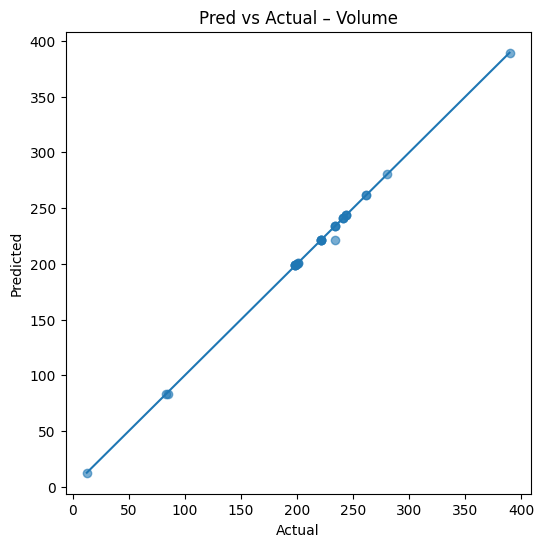

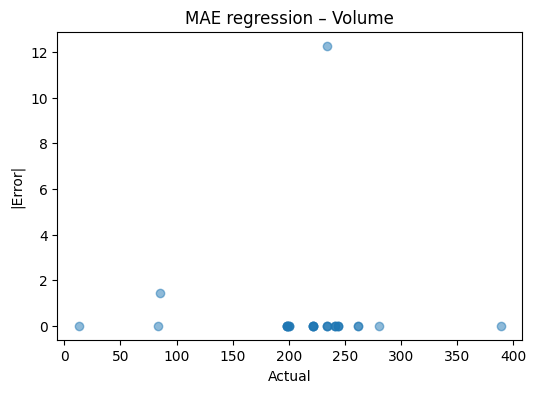


=== Weight(g) Metrics ===
count     : 30
mean_error: -0.3
MAE       : 0.3
MAPE(%)   : 0.15384615384615385
MSE       : 2.7
RMSE      : 1.6431676725154984
R2        : 0.9986862315443916


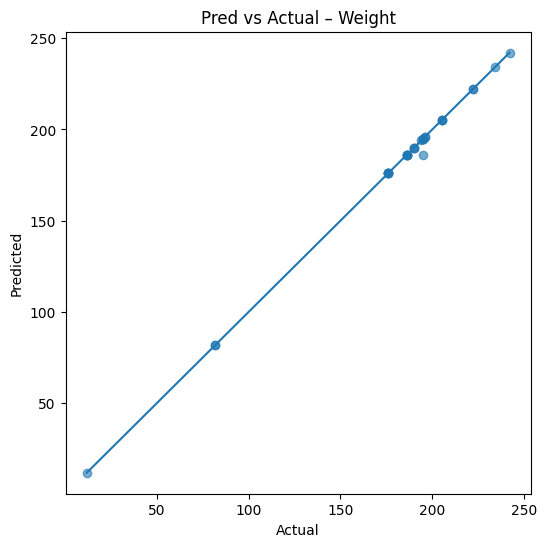

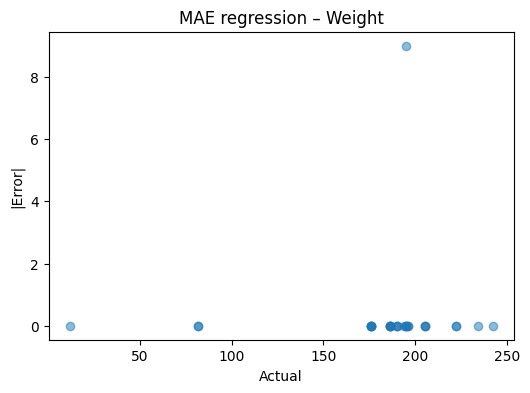

In [ ]:
# ==== FINAL Colab Cell: Parallel evaluation on tuned Gemini endpoint (no syntax errors) ====

MAX_EVAL     = 200
MAX_WORKERS  = 8
TARGET_QPS   = 4.0
REPORT_EVERY = 20

PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"
TUNING_JOB_NAME   = "projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576"
MODEL_NAME        = "projects/927828199877/locations/us-central1/models/5948862582105309184@1"
ENDPOINT_NAME     = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

import io, json, math, re, time, requests, threading
import numpy as np, matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
try:
    from google.cloud import storage
except ImportError:
    !pip -q install --no-deps google-cloud-storage==2.16.0
    from google.cloud import storage

# --- Auth ---
colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())
TOKEN=creds.token
session=requests.Session()
session.headers.update({"Authorization":f"Bearer {TOKEN}","Content-Type":"application/json"})

# --- Helpers ---
def _region_from_resource(name): return name.split("/")[name.split("/").index("locations")+1]
def _gcs_client(): return storage.Client(credentials=creds)
def _split_gs(gs_uri): b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
def _gcs_read_text(gs_uri): b,p=_split_gs(gs_uri); return _gcs_client().bucket(b).blob(p).download_as_text()

def _guess_mime(uri):
    ext=re.search(r"\.([A-Za-z0-9]+)$",uri.split("?")[0])
    ext=(ext.group(1).lower() if ext else "jpg")
    return {"jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
            "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"}.get(ext,"image/jpeg")

def _endpoint_generate_json(endpoint,image_uri,prompt_text,timeout=60,max_retries=4):
    loc=_region_from_resource(endpoint)
    url=f"https://{loc}-aiplatform.googleapis.com/v1/{endpoint}:generateContent"
    payload={"contents":[{"role":"user","parts":[
                {"fileData":{"mimeType":_guess_mime(image_uri),"fileUri":image_uri}},
                {"text":prompt_text}]}],
             "generationConfig":{"temperature":0.0,"maxOutputTokens":64}}
    backoff=1
    for _ in range(max_retries):
        try:
            r=session.post(url,json=payload,timeout=timeout)
            if r.status_code==200:
                try:
                    t=r.json()["candidates"][0]["content"]["parts"][0]["text"]
                    return json.loads(t.strip().strip("`"))
                except: return None
            if r.status_code in (408,429,500,502,503,504):
                time.sleep(backoff); backoff=min(backoff*2,8); continue
            print(f"[warn] {r.status_code}: {r.text[:150]}"); return None
        except Exception: time.sleep(backoff); backoff=min(backoff*2,8)
    return None

def _metrics(y_true,y_pred):
    y_true=np.asarray(y_true,float); y_pred=np.asarray(y_pred,float)
    err=y_pred-y_true
    with np.errstate(divide="ignore",invalid="ignore"):
        ape=np.abs(err/y_true)*100; ape=ape[~np.isinf(ape)&~np.isnan(ape)]
    return {"count":len(y_true),"mean_error":float(np.mean(err)),
            "MAE":float(mean_absolute_error(y_true,y_pred)),
            "MAPE(%)":float(np.mean(ape)) if len(ape) else float("nan"),
            "MSE":float(mean_squared_error(y_true,y_pred)),
            "RMSE":float(math.sqrt(mean_squared_error(y_true,y_pred))),
            "R2":float(r2_score(y_true,y_pred))}

def _print_metrics(name,m):
    print(f"\n=== {name} Metrics ===")
    for k,v in m.items(): print(f"{k:10s}: {v}")

def _plots(y_true,y_pred,title):
    y_true,y_pred=np.asarray(y_true,float),np.asarray(y_pred,float)
    plt.figure(figsize=(6,6)); plt.scatter(y_true,y_pred,alpha=0.6)
    mn,mx=min(y_true.min(),y_pred.min()),max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx]); plt.title(f"Pred vs Actual – {title}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.show()
    plt.figure(figsize=(6,4)); plt.scatter(y_true,np.abs(y_true-y_pred),alpha=0.5)
    plt.title(f"MAE regression – {title}"); plt.xlabel("Actual"); plt.ylabel("|Error|"); plt.show()

# --- Load validation data ---
job=requests.get(f"https://{LOCATION}-aiplatform.googleapis.com/v1/{TUNING_JOB_NAME}",
                 headers={"Authorization":f"Bearer {TOKEN}"},timeout=60).json()
uris=[u for v in job.values() for u in str(v).split() if u.startswith("gs://")]
val=[u for u in uris if "val.jsonl" in u]
VAL_JSONL=val[0] if val else "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
raw=_gcs_read_text(VAL_JSONL).splitlines()
examples=[json.loads(l) for l in raw if l.strip()]
if MAX_EVAL: examples=examples[:MAX_EVAL]
print(f"Using {len(examples)} examples from {VAL_JSONL}")

# --- Extract IO pairs ---
def _extract(ex):
    try:
        user,model=ex["contents"][0],ex["contents"][1]
        gt=json.loads(model["parts"][0]["text"])
        yv,yw=float(gt["volume_cm3"]),float(gt["weight_g"])
        f,p=None,""
        for part in user["parts"]:
            if "fileData" in part: f=part["fileData"]["fileUri"]
            elif "text" in part: p=part["text"]
        return (f,p,yv,yw) if (f and p) else None
    except: return None

ios=[i for e in examples if (i:=_extract(e))]

# --- Parallel inference ---
pairs_vol,pairs_wt=[],[]
done=0; lock=threading.Lock(); start=time.time()

def worker(args):
    f,p,yv,yw=args
    pred=_endpoint_generate_json(ENDPOINT_NAME,f,p)
    pv=pw=np.nan
    if pred:
        def _num(x):
            try: return float(x)
            except: return float(re.sub(r"[^0-9eE\.\-\+]", "", str(x)) or "nan")
        pv=_num(pred.get("volume_cm3",np.nan)); pw=_num(pred.get("weight_g",np.nan))
    global done
    with lock:
        if not np.isnan(pv): pairs_vol.append((yv,pv))
        if not np.isnan(pw): pairs_wt.append((yw,pw))
        done+=1
        if done%REPORT_EVERY==0 or done==len(ios):
            print(f"progress: {done}/{len(ios)} in {time.time()-start:.1f}s")

print(f"Scoring {len(ios)} examples with {MAX_WORKERS} threads…")
with ThreadPoolExecutor(MAX_WORKERS) as pool:
    for _ in as_completed([pool.submit(worker,a) for a in ios]): pass

print(f"Finished {done}/{len(ios)} in {time.time()-start:.1f}s")
if pairs_vol: yv_t,yv_p=zip(*pairs_vol); mv=_metrics(yv_t,yv_p); _print_metrics("Volume(cm³)",mv); _plots(yv_t,yv_p,"Volume")
if pairs_wt:  yw_t,yw_p=zip(*pairs_wt); mw=_metrics(yw_t,yw_p); _print_metrics("Weight(g)",mw); _plots(yw_t,yw_p,"Weight")
if not pairs_vol and not pairs_wt: print("No usable prediction pairs.")


(0.01, 3)

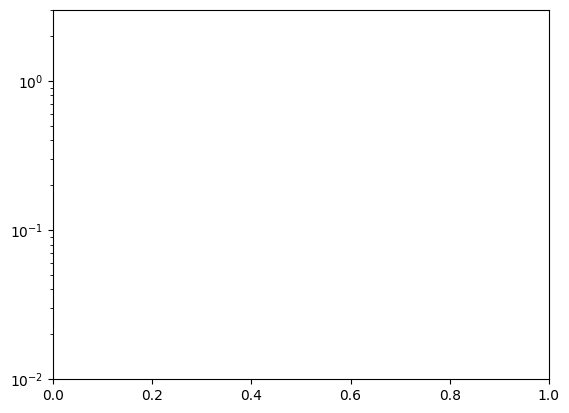

In [ ]:
plt.yscale("log")
plt.ylim(1e-2, 3)  # start just above zero


Using 454 examples from gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl
Scoring 454 examples with 8 threads…
progress: 20/454 in 6.8s
progress: 40/454 in 11.5s
progress: 60/454 in 16.3s
progress: 80/454 in 21.1s
progress: 100/454 in 25.5s
progress: 120/454 in 30.2s
progress: 140/454 in 34.5s
progress: 160/454 in 38.6s
progress: 180/454 in 42.4s
progress: 200/454 in 46.8s
progress: 220/454 in 50.9s
progress: 240/454 in 55.0s
progress: 260/454 in 58.6s
progress: 280/454 in 62.4s
progress: 300/454 in 66.7s
progress: 320/454 in 70.0s
progress: 340/454 in 74.4s
progress: 360/454 in 78.2s
progress: 380/454 in 81.9s
progress: 400/454 in 86.7s
progress: 420/454 in 90.3s
progress: 440/454 in 93.9s
progress: 454/454 in 96.7s
Finished 454/454 in 96.8s

=== Volume(cm³) Metrics ===
count     : 77
mean_error: -0.2148051948051949
MAE       : 0.2148051948051949
MAPE(%)   : 0.1333617584044388
MSE       : 2.0369818181818187
RMSE      : 1.427

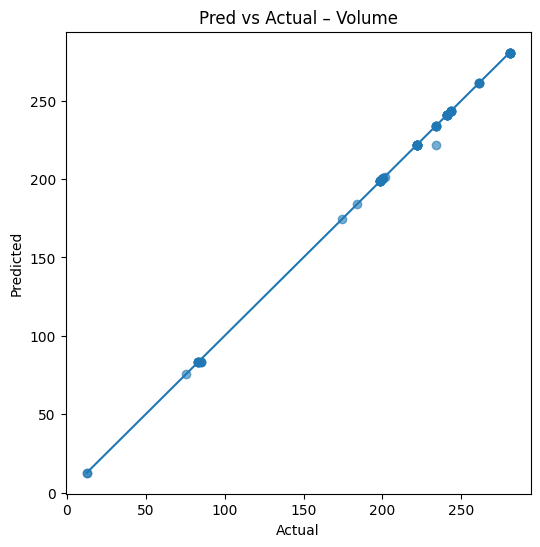

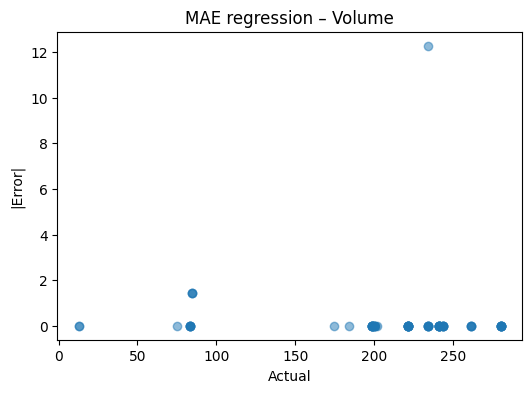


=== Weight(g) Metrics ===
count     : 77
mean_error: -0.11688311688311688
MAE       : 0.11688311688311688
MAPE(%)   : 0.059940059940059943
MSE       : 1.051948051948052
RMSE      : 1.0256451881367417
R2        : 0.999602912408602


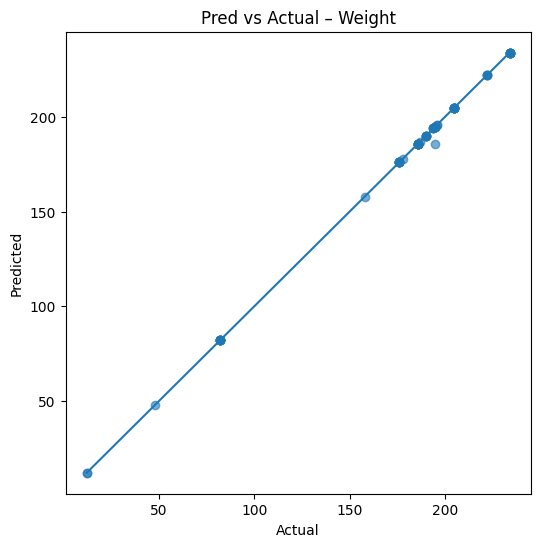

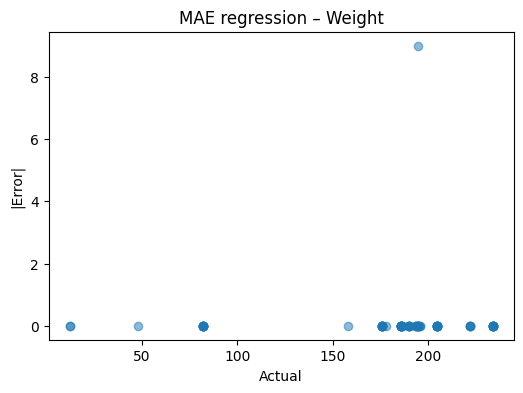

In [ ]:
# ==== FINAL Colab Cell: Parallel evaluation on tuned Gemini endpoint (no syntax errors) ====

MAX_EVAL     = None
MAX_WORKERS  = 8
TARGET_QPS   = 4.0
REPORT_EVERY = 20

PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"
TUNING_JOB_NAME   = "projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576"
MODEL_NAME        = "projects/927828199877/locations/us-central1/models/5948862582105309184@1"
ENDPOINT_NAME     = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

import io, json, math, re, time, requests, threading
import numpy as np, matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
try:
    from google.cloud import storage
except ImportError:
    !pip -q install --no-deps google-cloud-storage==2.16.0
    from google.cloud import storage

# --- Auth ---
colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())
TOKEN=creds.token
session=requests.Session()
session.headers.update({"Authorization":f"Bearer {TOKEN}","Content-Type":"application/json"})

# --- Helpers ---
def _region_from_resource(name): return name.split("/")[name.split("/").index("locations")+1]
def _gcs_client(): return storage.Client(credentials=creds)
def _split_gs(gs_uri): b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
def _gcs_read_text(gs_uri): b,p=_split_gs(gs_uri); return _gcs_client().bucket(b).blob(p).download_as_text()

def _guess_mime(uri):
    ext=re.search(r"\.([A-Za-z0-9]+)$",uri.split("?")[0])
    ext=(ext.group(1).lower() if ext else "jpg")
    return {"jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
            "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"}.get(ext,"image/jpeg")

def _endpoint_generate_json(endpoint,image_uri,prompt_text,timeout=60,max_retries=4):
    loc=_region_from_resource(endpoint)
    url=f"https://{loc}-aiplatform.googleapis.com/v1/{endpoint}:generateContent"
    payload={"contents":[{"role":"user","parts":[
                {"fileData":{"mimeType":_guess_mime(image_uri),"fileUri":image_uri}},
                {"text":prompt_text}]}],
             "generationConfig":{"temperature":0.0,"maxOutputTokens":64}}
    backoff=1
    for _ in range(max_retries):
        try:
            r=session.post(url,json=payload,timeout=timeout)
            if r.status_code==200:
                try:
                    t=r.json()["candidates"][0]["content"]["parts"][0]["text"]
                    return json.loads(t.strip().strip("`"))
                except: return None
            if r.status_code in (408,429,500,502,503,504):
                time.sleep(backoff); backoff=min(backoff*2,8); continue
            print(f"[warn] {r.status_code}: {r.text[:150]}"); return None
        except Exception: time.sleep(backoff); backoff=min(backoff*2,8)
    return None

def _metrics(y_true,y_pred):
    y_true=np.asarray(y_true,float); y_pred=np.asarray(y_pred,float)
    err=y_pred-y_true
    with np.errstate(divide="ignore",invalid="ignore"):
        ape=np.abs(err/y_true)*100; ape=ape[~np.isinf(ape)&~np.isnan(ape)]
    return {"count":len(y_true),"mean_error":float(np.mean(err)),
            "MAE":float(mean_absolute_error(y_true,y_pred)),
            "MAPE(%)":float(np.mean(ape)) if len(ape) else float("nan"),
            "MSE":float(mean_squared_error(y_true,y_pred)),
            "RMSE":float(math.sqrt(mean_squared_error(y_true,y_pred))),
            "R2":float(r2_score(y_true,y_pred))}

def _print_metrics(name,m):
    print(f"\n=== {name} Metrics ===")
    for k,v in m.items(): print(f"{k:10s}: {v}")

def _plots(y_true,y_pred,title):
    y_true,y_pred=np.asarray(y_true,float),np.asarray(y_pred,float)
    plt.figure(figsize=(6,6)); plt.scatter(y_true,y_pred,alpha=0.6)
    mn,mx=min(y_true.min(),y_pred.min()),max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx]); plt.title(f"Pred vs Actual – {title}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.show()
    plt.figure(figsize=(6,4)); plt.scatter(y_true,np.abs(y_true-y_pred),alpha=0.5)
    plt.title(f"MAE regression – {title}"); plt.xlabel("Actual"); plt.ylabel("|Error|"); plt.show()

# --- Load validation data ---
job=requests.get(f"https://{LOCATION}-aiplatform.googleapis.com/v1/{TUNING_JOB_NAME}",
                 headers={"Authorization":f"Bearer {TOKEN}"},timeout=60).json()
uris=[u for v in job.values() for u in str(v).split() if u.startswith("gs://")]
val=[u for u in uris if "val.jsonl" in u]
VAL_JSONL=val[0] if val else "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
raw=_gcs_read_text(VAL_JSONL).splitlines()
examples=[json.loads(l) for l in raw if l.strip()]
if MAX_EVAL: examples=examples[:MAX_EVAL]
print(f"Using {len(examples)} examples from {VAL_JSONL}")

# --- Extract IO pairs ---
def _extract(ex):
    try:
        user,model=ex["contents"][0],ex["contents"][1]
        gt=json.loads(model["parts"][0]["text"])
        yv,yw=float(gt["volume_cm3"]),float(gt["weight_g"])
        f,p=None,""
        for part in user["parts"]:
            if "fileData" in part: f=part["fileData"]["fileUri"]
            elif "text" in part: p=part["text"]
        return (f,p,yv,yw) if (f and p) else None
    except: return None

ios=[i for e in examples if (i:=_extract(e))]

# --- Parallel inference ---
pairs_vol,pairs_wt=[],[]
done=0; lock=threading.Lock(); start=time.time()

def worker(args):
    f,p,yv,yw=args
    pred=_endpoint_generate_json(ENDPOINT_NAME,f,p)
    pv=pw=np.nan
    if pred:
        def _num(x):
            try: return float(x)
            except: return float(re.sub(r"[^0-9eE\.\-\+]", "", str(x)) or "nan")
        pv=_num(pred.get("volume_cm3",np.nan)); pw=_num(pred.get("weight_g",np.nan))
    global done
    with lock:
        if not np.isnan(pv): pairs_vol.append((yv,pv))
        if not np.isnan(pw): pairs_wt.append((yw,pw))
        done+=1
        if done%REPORT_EVERY==0 or done==len(ios):
            print(f"progress: {done}/{len(ios)} in {time.time()-start:.1f}s")

print(f"Scoring {len(ios)} examples with {MAX_WORKERS} threads…")
with ThreadPoolExecutor(MAX_WORKERS) as pool:
    for _ in as_completed([pool.submit(worker,a) for a in ios]): pass

print(f"Finished {done}/{len(ios)} in {time.time()-start:.1f}s")
if pairs_vol: yv_t,yv_p=zip(*pairs_vol); mv=_metrics(yv_t,yv_p); _print_metrics("Volume(cm³)",mv); _plots(yv_t,yv_p,"Volume")
if pairs_wt:  yw_t,yw_p=zip(*pairs_wt); mw=_metrics(yw_t,yw_p); _print_metrics("Weight(g)",mw); _plots(yw_t,yw_p,"Weight")
if not pairs_vol and not pairs_wt: print("No usable prediction pairs.")


In [ ]:
# ==== ONE-CELL: Export actual values from your validation JSONL to Excel ====

import json, pandas as pd
from google.cloud import storage
from google.colab import auth as colab_auth

# --- CONFIG ---
PROJECT_ID = "927828199877"
VAL_JSONL  = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
EXCEL_PATH = "/content/val_actuals.xlsx"

# --- AUTH & INIT ---
colab_auth.authenticate_user()
client = storage.Client(project=PROJECT_ID)

# --- LOAD JSONL ---
def _split_gs(gs_uri):
    b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
b,p=_split_gs(VAL_JSONL)
blob = client.bucket(b).blob(p)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines if l.strip()]

# --- EXTRACT actual values ---
rows=[]
for ex in examples:
    try:
        user, model = ex["contents"][0], ex["contents"][1]
        gt = json.loads(model["parts"][0]["text"])
        yv, yw = gt.get("volume_cm3"), gt.get("weight_g")
        f_uri, prompt = None, ""
        for part in user["parts"]:
            if "fileData" in part: f_uri = part["fileData"]["fileUri"]
            elif "text" in part:  prompt = part["text"]
        rows.append({
            "image_uri": f_uri,
            "prompt": prompt,
            "actual_volume_cm3": yv,
            "actual_weight_g": yw
        })
    except Exception as e:
        print("skip:", e)

df = pd.DataFrame(rows)
print("Extracted rows:", len(df))
display(df.head(10))

# --- SAVE ---
df.to_excel(EXCEL_PATH, index=False)
print(f"\n✅ Saved ground-truth validation data to {EXCEL_PATH}")
from google.colab import files; files.download(EXCEL_PATH)


Extracted rows: 454


,image_uri,prompt,actual_volume_cm3,actual_weight_g
0,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,23.67,12.0
1,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,175.08,167.0
2,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,240.84,205.0
3,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,174.41,158.0
4,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,175.08,167.0
5,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,75.37,48.0
6,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,199.83,194.0
7,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,174.41,158.0
8,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,243.52,190.0
9,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,200.55,196.0



✅ Saved ground-truth validation data to /content/val_actuals.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==== FINAL: Multimodal tuned Gemini batch evaluation ====

import json, re, time, math, pandas as pd, numpy as np, requests
from tqdm import tqdm
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest

# ---------------- CONFIG ----------------
PROJECT_ID    = "927828199877"
LOCATION      = "us-central1"
ENDPOINT_NAME = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

INPUT_XLSX    = "/content/val_actuals.xlsx"   # must have: image_uri, prompt, actual_volume_cm3, actual_weight_g
OUTPUT_XLSX   = "/content/comparison_eval.xlsx"
MAX_EXAMPLES  = 50    # set None to process all

# ---------------- AUTH ----------------
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
TOKEN = creds.token

session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {TOKEN}",
    "Content-Type": "application/json",
})
API_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_NAME}:generateContent"

# ---------------- HELPERS ----------------
def _guess_mime(uri: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png",
        "webp":"image/webp","bmp":"image/bmp","tif":"image/tiff",
        "tiff":"image/tiff","gif":"image/gif"
    }.get(ext,"image/jpeg")

def call_generate(image_uri, prompt_text, timeout=90):
    """Send one image+text request to the tuned Gemini endpoint."""
    body = {
      "contents": [{
        "role": "user",
        "parts": [
          {"fileData": {"fileUri": image_uri, "mimeType": _guess_mime(image_uri)}},
          {"text": str(prompt_text)}
        ]
      }],
      "generationConfig": {
        "temperature": 0.0,
        "maxOutputTokens": 128,
        "responseMimeType": "application/json",
        "responseSchema": {
          "type": "OBJECT",
          "properties": {
            "volume_cm3": {"type": "NUMBER"},
            "weight_g":   {"type": "NUMBER"}
          },
          "required": ["volume_cm3", "weight_g"]
        }
      }
    }
    r = session.post(API_URL, json=body, timeout=timeout)
    if r.status_code != 200:
        print(f"[HTTP {r.status_code}] {r.text[:200]}")
        return None
    try:
        data = r.json()
        txt = data["candidates"][0]["content"]["parts"][0]["text"]
        return json.loads(txt)
    except Exception as e:
        print("[warn] could not parse JSON:", e)
        return None

def fnum(x):
    try: return float(x)
    except: return np.nan

# ---------------- LOAD INPUT ----------------
df = pd.read_excel(INPUT_XLSX)
if MAX_EXAMPLES:
    df = df.head(MAX_EXAMPLES)
print(f"Loaded {len(df)} examples")

# ---------------- RUN INFERENCE ----------------
pred_vols, pred_wgts = [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    label = f"[{i+1}/{len(df)}]"
    image_uri = row["image_uri"]
    prompt_text = row["prompt"]

    pred = call_generate(image_uri, prompt_text)
    if pred and isinstance(pred, dict):
        v = fnum(pred.get("volume_cm3"))
        w = fnum(pred.get("weight_g"))
        pred_vols.append(v)
        pred_wgts.append(w)
        print(f"{label} ✓ volume={v} weight={w}")
    else:
        pred_vols.append(np.nan)
        pred_wgts.append(np.nan)
        print(f"{label} ⚠ no prediction")

# ---------------- SAVE OUTPUT ----------------
df["tuned_volume_cm3"] = pred_vols
df["tuned_weight_g"]   = pred_wgts
df.to_excel(OUTPUT_XLSX, index=False)
print(f"\n✅ Saved {len(df)} rows to {OUTPUT_XLSX}")
from google.colab import files; files.download(OUTPUT_XLSX)


Loaded 50 examples


  2%|▏         | 1/50 [00:02<01:51,  2.27s/it]

[warn] could not parse JSON: Expecting value: line 1 column 1 (char 0)
[1/50] ⚠ no prediction


  4%|▍         | 2/50 [00:04<01:55,  2.40s/it]

[warn] could not parse JSON: Expecting value: line 1 column 1 (char 0)
[2/50] ⚠ no prediction


  4%|▍         | 2/50 [00:06<02:40,  3.35s/it]


KeyboardInterrupt: 

In [ ]:
# ==== RECREATE val_actuals.xlsx from GCS validation JSONL ====
import json, pandas as pd
from google.colab import auth as colab_auth
from google.cloud import storage

# --- CONFIG ---
PROJECT_ID = "927828199877"
VAL_JSONL  = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
OUT_PATH   = "/content/val_actuals.xlsx"

# --- AUTH & INIT ---
colab_auth.authenticate_user()
client = storage.Client(project=PROJECT_ID)

# --- LOAD JSONL ---
def _split_gs(uri):
    b,*r = uri[5:].split("/",1)
    return b,(r[0] if r else "")
b,p = _split_gs(VAL_JSONL)
blob = client.bucket(b).blob(p)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines if l.strip()]

# --- EXTRACT image + prompt + targets ---
rows = []
for ex in examples:
    try:
        user = ex["contents"][0]
        model = ex["contents"][1]
        gt = json.loads(model["parts"][0]["text"])
        yv, yw = gt.get("volume_cm3"), gt.get("weight_g")
        f_uri, prompt = None, ""
        for part in user["parts"]:
            if "fileData" in part:
                f_uri = part["fileData"]["fileUri"]
            elif "text" in part:
                prompt = part["text"]
        if f_uri and prompt and yv is not None and yw is not None:
            rows.append({
                "image_uri": f_uri,
                "prompt": prompt,
                "actual_volume_cm3": yv,
                "actual_weight_g": yw
            })
    except Exception as e:
        pass

df = pd.DataFrame(rows)
df.to_excel(OUT_PATH, index=False)
print(f"✅ Recreated {len(df)} validation rows → {OUT_PATH}")
from google.colab import files; files.download(OUT_PATH)


✅ Recreated 454 validation rows → /content/val_actuals.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==== FINAL ONE-CELL: Batched (50) Base vs Tuned with auto-refresh & Drive checkpoints ====
import os, json, re, time, base64, pandas as pd, numpy as np
from tqdm import tqdm
from google.colab import auth as colab_auth, drive as colab_drive
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession

# ---------------- CONFIG ----------------
PROJECT_ID      = "927828199877"
LOCATION        = "us-central1"
ENDPOINT_TUNED  = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"
BASE_MODEL_PATH = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

INPUT_XLSX   = "/content/val_actuals.xlsx"
DRIVE_DIR    = "/content/drive/MyDrive/gemini_evals"   # change if you like
OUTPUT_BASENAME = "comparison_eval.xlsx"               # rolling file (overwritten each batch)
BATCH_SIZE   = 50
MAX_EXAMPLES = None        # None = full run
RETRIES      = 1
RETRY_SLEEP  = 1.0
MAX_TOKENS   = 2048
POST_TIMEOUT = 120
GET_TIMEOUT  = 45

# ---------------- AUTH (Vertex auto-refresh) ----------------
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

URL_BASE  = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{BASE_MODEL_PATH}:generateContent"
URL_TUNED = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_TUNED}:generateContent"

# ---------------- MOUNT DRIVE (prompt ONCE per session) ----------------
colab_drive.mount("/content/drive", force_remount=False)
os.makedirs(DRIVE_DIR, exist_ok=True)
OUTPUT_XLSX = os.path.join(DRIVE_DIR, OUTPUT_BASENAME)

# ---------------- HELPERS ----------------
def _guess_mime(uri: str):
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _load_bytes_b64(uri):
    mime = _guess_mime(uri)
    if uri.startswith("gs://"):
        from google.cloud import storage
        bkt, path = uri[5:].split("/", 1)
        blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
        data = blob.download_as_bytes()
    else:
        r = session.get(uri, timeout=GET_TIMEOUT)
        r.raise_for_status()
        data = r.content
    return mime, base64.b64encode(data).decode("utf-8")

def _clean_json_text(txt):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

FEWSHOT = [
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Apple\nWidth (in): 3.40\nHeight (in): 3.60"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 242.0, "weight_g": 205.0}'}]},
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Banana\nWidth (in): 6.10\nHeight (in): 2.40"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 200.0, "weight_g": 185.0}'}]},
]

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

def fnum(x):
    try: return float(x)
    except: return np.nan

# ---- Base ----
def predict_base_inline(image_uri, prompt, label):
    try:
        mime, b64 = _load_bytes_b64(image_uri)
    except Exception as e:
        print(f"{label} base [load-error] {e}")
        return None
    body = {
        "contents": FEWSHOT + [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":b64}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_BASE, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} base [HTTP {r.status_code}] {r.text[:120]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except: return None

# ---- Tuned ----
def predict_tuned_fileuri(image_uri, prompt, label):
    body = {
        "contents":[{
            "role":"user",
            "parts":[
                {"fileData":{"fileUri":image_uri,"mimeType":_guess_mime(image_uri)}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_TUNED, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} tuned [HTTP {r.status_code}] {r.text[:120]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except: return None

# ---------------- LOAD INPUT ----------------
df = pd.read_excel(INPUT_XLSX)
if MAX_EXAMPLES: df = df.head(MAX_EXAMPLES)
print(f"Loaded {len(df)} examples")

# Ensure result columns exist (supports resume)
for c in ["base_volume_cm3","base_weight_g","tuned_volume_cm3","tuned_weight_g"]:
    if c not in df.columns: df[c] = np.nan

# Resume point: first row missing tuned result
start_idx = int(df[df["tuned_volume_cm3"].isna()].index.min() or 0)
n = len(df)

# ---------------- BATCHED RUN (saves to Drive after each batch) ----------------
for start in range(start_idx, n, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n)
    batch = df.iloc[start:end]
    print(f"\n=== Processing rows {start+1}-{end}/{n} ===")

    for i, row in tqdm(batch.iterrows(), total=len(batch), leave=False):
        label = f"[{i+1}/{n}]"
        img, text = row["image_uri"], row["prompt"]

        # Base
        base_pred = predict_base_inline(img, text, label)
        tries = 0
        while (not base_pred) and tries < RETRIES:
            time.sleep(RETRY_SLEEP)
            base_pred = predict_base_inline(img, text, label+" (retry)")
            tries += 1

        # Tuned
        tuned_pred = predict_tuned_fileuri(img, text, label)
        tries = 0
        while (not tuned_pred) and tries < RETRIES:
            time.sleep(RETRY_SLEEP)
            tuned_pred = predict_tuned_fileuri(img, text, label+" (retry)")
            tries += 1

        bv = fnum(base_pred.get("volume_cm3")) if base_pred else np.nan
        bw = fnum(base_pred.get("weight_g"))   if base_pred else np.nan
        tv = fnum(tuned_pred.get("volume_cm3")) if tuned_pred else np.nan
        tw = fnum(tuned_pred.get("weight_g"))   if tuned_pred else np.nan

        df.loc[i, "base_volume_cm3"]  = bv
        df.loc[i, "base_weight_g"]    = bw
        df.loc[i, "tuned_volume_cm3"] = tv
        df.loc[i, "tuned_weight_g"]   = tw

    # Save a rolling checkpoint to Drive (overwrites same file)
    df.to_excel(OUTPUT_XLSX, index=False)
    print(f"✅ Saved checkpoint to: {OUTPUT_XLSX}")

print(f"\n✅ All {n} rows processed. Final saved at: {OUTPUT_XLSX}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 454 examples

=== Processing rows 1-50/454 ===



100%|██████████| 50/50 [23:46<00:00, 30.57s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 51-100/454 ===



100%|██████████| 50/50 [21:31<00:00, 30.00s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 101-150/454 ===



100%|██████████| 50/50 [19:52<00:00, 26.47s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 151-200/454 ===



100%|██████████| 50/50 [21:56<00:00, 29.88s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 201-250/454 ===



100%|██████████| 50/50 [20:22<00:00, 20.92s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 251-300/454 ===



100%|██████████| 50/50 [25:38<00:00, 35.58s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 301-350/454 ===



100%|██████████| 50/50 [21:27<00:00, 25.52s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 351-400/454 ===



100%|██████████| 50/50 [21:58<00:00, 28.32s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 401-450/454 ===



100%|██████████| 50/50 [21:35<00:00, 22.21s/it]
                                               

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

=== Processing rows 451-454/454 ===



100%|██████████| 4/4 [01:16<00:00, 19.15s/it]
                                             

✅ Saved checkpoint to: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx

✅ All 454 rows processed. Final saved at: /content/drive/MyDrive/gemini_evals/comparison_eval.xlsx


In [ ]:
import json, requests, google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
from google.colab import auth as colab_auth

PROJECT_ID="927828199877"
LOCATION="us-central1"
ENDPOINT="projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

IMAGE="gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24_jpg.rf.310cb87441fd05067873dc7ec52c6330.jpg"
TEXT="""Return **only valid JSON**, no words or code fences.
Use keys "volume_cm3" and "weight_g" (numbers only).
Label: Bell Pepper
Width (in): 116.535496
Height (in): 144.488267"""

colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
creds.refresh(GoogleAuthRequest())

url=f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT}:generateContent"
headers={"Authorization":f"Bearer {creds.token}","Content-Type":"application/json"}
body={
 "contents":[{"role":"user","parts":[
   {"fileData":{"fileUri":IMAGE,"mimeType":"image/jpeg"}},
   {"text":TEXT}]}],
 "generationConfig":{"temperature":0.0,"maxOutputTokens":1024}
}
r=requests.post(url,headers=headers,json=body,timeout=120)
print("HTTP",r.status_code)
print(json.dumps(r.json(),indent=2)[:1500])


HTTP 200
{
  "candidates": [
    {
      "content": {
        "role": "model",
        "parts": [
          {
            "text": "{\"volume_cm3\":23.67,\"weight_g\":12.0}"
          }
        ]
      },
      "finishReason": "STOP",
      "avgLogprobs": -0.01392761440504165
    }
  ],
  "usageMetadata": {
    "promptTokenCount": 326,
    "candidatesTokenCount": 21,
    "totalTokenCount": 347,
    "trafficType": "ON_DEMAND",
    "promptTokensDetails": [
      {
        "modality": "IMAGE",
        "tokenCount": 258
      },
      {
        "modality": "TEXT",
        "tokenCount": 68
      }
    ],
    "candidatesTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 21
      }
    ]
  },
  "modelVersion": "gemini-2.5-flash@default",
  "createTime": "2025-10-24T04:08:57.985652Z",
  "responseId": "2fv6aLSUPKCH3NoPqZW5gAo"
}


In [ ]:
# ==== ONE-CELL: Base Gemini 2.5 Flash (multimodal) with schema + few-shot ====
import json, re, requests, google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
from google.colab import auth as colab_auth

# --- CONFIG ---
PROJECT_ID = "927828199877"
LOCATION   = "us-central1"
BASE_MODEL = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

# Test sample (same style as your val file)
IMAGE_URI = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24_jpg.rf.310cb87441fd05067873dc7ec52c6330.jpg"
PROMPT_TEXT = """Return values for volume_cm3 and weight_g based on the object and dimensions below.
Label: Bell Pepper
Width (in): 116.535496
Height (in): 144.488267"""

# --- AUTH ---
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())

url = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{BASE_MODEL}:generateContent"
headers = {"Authorization": f"Bearer {creds.token}", "Content-Type": "application/json"}

# --- FEW-SHOT EXAMPLES (text-only exemplars to teach output shape) ---
fewshot_user_1  = """Return only the JSON object for these values.
Label: Apple
Width (in): 3.40
Height (in): 3.60"""
fewshot_model_1 = '{"volume_cm3": 242.0, "weight_g": 205.0}'

fewshot_user_2  = """Return only the JSON object for these values.
Label: Banana
Width (in): 6.10
Height (in): 2.40"""
fewshot_model_2 = '{"volume_cm3": 200.0, "weight_g": 185.0}'

# --- REQUEST BODY ---
body = {
  "contents": [
    # few-shot 1
    {"role": "user",  "parts": [{"text": fewshot_user_1}]},
    {"role": "model", "parts": [{"text": fewshot_model_1}]},
    # few-shot 2
    {"role": "user",  "parts": [{"text": fewshot_user_2}]},
    {"role": "model", "parts": [{"text": fewshot_model_2}]},
    # now the actual multimodal example
    {"role": "user", "parts": [
      {"fileData": {"fileUri": IMAGE_URI, "mimeType": "image/jpeg"}},
      {"text": (
        'Return *only* valid JSON with numeric keys "volume_cm3" and "weight_g". '
        'No code fences, no words.\n' + PROMPT_TEXT
      )}
    ]}
  ],
  "generationConfig": {
    "temperature": 0.0,
    "maxOutputTokens": 1024,
    "responseMimeType": "application/json",
    "responseSchema": {
      "type": "OBJECT",
      "properties": {
        "volume_cm3": {"type": "NUMBER"},
        "weight_g":   {"type": "NUMBER"}
      },
      "required": ["volume_cm3", "weight_g"]
    }
  }
}

# --- CALL ---
r = requests.post(url, headers=headers, json=body, timeout=120)
print("HTTP", r.status_code)
resp = r.json()
print(json.dumps(resp, indent=2)[:1000])

# --- PARSE (robust to stray formatting) ---
def parse_json_from_response(d):
    try:
        txt = d["candidates"][0]["content"]["parts"][0].get("text", "")
    except Exception:
        return None
    t = txt.strip().strip("`").lstrip("json").strip()
    t = re.sub(r"^json\s*", "", t, flags=re.I)
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        return json.loads(m.group(0)) if m else None

parsed = parse_json_from_response(resp)
print("\nParsed:", parsed)


HTTP 200
{
  "candidates": [
    {
      "content": {
        "role": "model",
        "parts": [
          {
            "text": "{\"volume_cm3\": 300.0, \"weight_g\": 200.0}\n"
          }
        ]
      },
      "finishReason": "MAX_TOKENS",
      "avgLogprobs": -6.877856914813702
    }
  ],
  "usageMetadata": {
    "promptTokenCount": 476,
    "candidatesTokenCount": 26,
    "totalTokenCount": 1488,
    "trafficType": "ON_DEMAND",
    "promptTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 218
      },
      {
        "modality": "IMAGE",
        "tokenCount": 258
      }
    ],
    "candidatesTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 26
      }
    ],
    "thoughtsTokenCount": 986
  },
  "modelVersion": "gemini-2.5-flash",
  "createTime": "2025-10-24T04:15:44.230528Z",
  "responseId": "cP36aICJDqeonvgPirTKyQE"
}

Parsed: {'volume_cm3': 300.0, 'weight_g': 200.0}


In [ ]:
# ==== SweetPotato: Base vs Tuned (checkpoint every 50) ====
# - Validation-only or ALL rows selection
# - Uses tuned MODEL NAME (no endpoint needed)
# - Robust tuned calls (schema fallback, retries) + logging
# - Writes Excel after each batch (50 rows)

import os, json, re, time, base64, math, concurrent.futures as cf
import pandas as pd, numpy as np
from tqdm import tqdm

# ---------------- USER CONFIG ----------------
PROJECT_ID       = "927828199877"
LOCATION         = "us-central1"

# Tuned model *name* (from your message)
TUNED_MODEL_NAME = "projects/927828199877/locations/us-central1/models/8949350649468813312@1"

ENDPOINT_NAME      = "projects/927828199877/locations/us-central1/endpoints/9079440467220758528"

# Base model
BASE_MODEL_PATH  = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

# Validation JSONL you'd like to use to restrict rows (set to the exact run you want):
VAL_JSONL_URI = "gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl"

# Drive output
DRIVE_DIR       = "/content/drive/MyDrive/gemini_evals"
OUTPUT_XLSX     = os.path.join(DRIVE_DIR, "comparison_eval_sweetpotato_all.xlsx")  # your file

# Behavior
ONLY_VALIDATION = True     # ← set False if you want to update ALL rows in the Excel
BATCH_SIZE      = 50
MAX_EXAMPLES    = None     # None = all selected rows
RETRIES         = 2
RETRY_SLEEP_S   = 2.0
MAX_TOKENS      = 2048
POST_TIMEOUT    = 120
GET_TIMEOUT     = 45
WORKERS         = 8        # parallel tuned calls; tweak if you see quota/429s

# ---------------- AUTH (Vertex + Drive) ----------------
try:
    from google.colab import auth as colab_auth, drive as colab_drive
    colab_auth.authenticate_user()
    IN_COLAB = True
except Exception:
    IN_COLAB = False

import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

# Drive mount
if IN_COLAB:
    try:
        from google.colab import drive as colab_drive
        colab_drive.mount("/content/drive", force_remount=False)
    except Exception:
        pass
os.makedirs(DRIVE_DIR, exist_ok=True)

# ---------------- URLs ----------------
def _url_models_generate(model_name: str) -> str:
    # e.g.: projects/.../locations/.../models/<id>@1:generateContent
    return f"https://{LOCATION}-aiplatform.googleapis.com/v1/{model_name}:generateContent"

URL_BASE  = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{BASE_MODEL_PATH}:generateContent"

URL_TUNED = _url_endpoints_generate(ENDPOINT_NAME)

# ---------------- HELPERS ----------------
def _guess_mime(uri: str):
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _load_bytes_b64(uri: str):
    mime = _guess_mime(uri)
    if uri.startswith("gs://"):
        from google.cloud import storage
        bkt, path = uri[5:].split("/", 1)
        blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
        data = blob.download_as_bytes()
    else:
        r = session.get(uri, timeout=GET_TIMEOUT)
        r.raise_for_status()
        data = r.content
    return mime, base64.b64encode(data).decode("utf-8")

def _clean_json_text(txt: str):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt: str):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

def _fnum(x):
    try: return float(x)
    except: return np.nan

# ---- Base prediction (inline image for fairness) ----
def predict_base_inline(image_uri, prompt, label):
    try:
        mime, b64 = _load_bytes_b64(image_uri)
    except Exception as e:
        print(f"{label} base [load-error] {e}")
        return None
    body = {
        "contents": [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":b64}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_BASE, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} base [HTTP {r.status_code}] {r.text[:200]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except Exception:
        return None

# ---- Tuned (robust) ----
def predict_tuned_fileuri(image_uri, prompt, label, *, retries=RETRIES, backoff=RETRY_SLEEP_S):
    """
    Calls tuned model at URL_TUNED.
    - Logs non-200 responses (first 200 chars).
    - Retries with exponential backoff.
    - Falls back to no-schema if schema validation fails.
    Returns dict {"volume_cm3": float, "weight_g": float} or None.
    """
    def _call(with_schema=True):
        body = {
            "contents":[{
                "role":"user",
                "parts":[
                    {"fileData":{"fileUri":image_uri,"mimeType":_guess_mime(image_uri)}},
                    {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                             'No code fences, no words.\n'+prompt)}
                ]
            }],
            "generationConfig": _genconfig(with_schema)
        }
        return session.post(URL_TUNED, json=body, timeout=POST_TIMEOUT,
                            headers={"Content-Type":"application/json"})

    attempt = 0
    while attempt <= retries:
        # try WITH schema
        r = _call(with_schema=True)
        if r.status_code == 200:
            try:
                txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
                out = _parse_json(txt)
                if isinstance(out, dict) and "volume_cm3" in out and "weight_g" in out:
                    return out
            except Exception:
                pass
            # fallback NO schema
            r2 = _call(with_schema=False)
            if r2.status_code == 200:
                try:
                    txt2 = r2.json()["candidates"][0]["content"]["parts"][0].get("text","")
                    out2 = _parse_json(txt2)
                    if isinstance(out2, dict) and "volume_cm3" in out2 and "weight_g" in out2:
                        return out2
                except Exception:
                    pass
            else:
                print(f"{label} tuned [HTTP {r2.status_code}] {r2.text[:200]}")
        else:
            print(f"{label} tuned [HTTP {r.status_code}] {r.text[:200]}")

        attempt += 1
        if attempt <= retries:
            time.sleep(backoff * attempt)

    return None

# ---------------- Load Excel ----------------
assert os.path.exists(OUTPUT_XLSX), f"Excel file not found: {OUTPUT_XLSX}\nOpen Drive left pane and verify the path."
df = pd.read_excel(OUTPUT_XLSX)
print(f"Loaded {len(df)} rows from Excel")

# Ensure expected cols exist (for resume/idempotence)
for c in ["base_volume_cm3","base_weight_g","tuned_volume_cm3","tuned_weight_g"]:
    if c not in df.columns:
        df[c] = np.nan

# ---------------- Restrict to VALIDATION set (optional) ----------------
if ONLY_VALIDATION:
    from google.cloud import storage
    bkt, path = VAL_JSONL_URI.replace("gs://","").split("/", 1)
    blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
    val_lines = blob.download_as_text().splitlines()
    val_ex = [json.loads(l) for l in val_lines]
    val_uris = set(
        ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        for ex in val_ex
        if ex["contents"][0]["parts"] and "fileData" in ex["contents"][0]["parts"][0]
    )
    print("Validation rows in JSONL:", len(val_uris))
    before = len(df)
    df = df[df["image_uri"].isin(val_uris)].reset_index(drop=True)
    print("Rows in Excel that are part of VALIDATION:", len(df), f"(filtered from {before})")

# Optional limit for quick runs
if MAX_EXAMPLES:
    df = df.head(MAX_EXAMPLES).copy()

# ---------------- Batch update (TUNED only, or both) ----------------
print("Using tuned model:", TUNED_MODEL_NAME)
print("Base model path :", BASE_MODEL_PATH)
print("Saving to       :", OUTPUT_XLSX)

def _proc_row(i_row_tuple):
    i, row = i_row_tuple
    label = f"[{i+1}/{len(df)}]"
    img   = row["image_uri"]
    text  = row["prompt"]

    # If base missing, you can compute here (comment out if not needed)
    bv = row.get("base_volume_cm3", np.nan)
    bw = row.get("base_weight_g", np.nan)
    if (pd.isna(bv) or pd.isna(bw)):
        base_pred = predict_base_inline(img, text, label)
        if base_pred:
            bv = _fnum(base_pred.get("volume_cm3"))
            bw = _fnum(base_pred.get("weight_g"))

    tuned_pred = predict_tuned_fileuri(img, text, label, retries=RETRIES, backoff=RETRY_SLEEP_S)
    if tuned_pred:
        tv = _fnum(tuned_pred.get("volume_cm3"))
        tw = _fnum(tuned_pred.get("weight_g"))
    else:
        tv, tw = np.nan, np.nan

    return i, bv, bw, tv, tw

start_idx = int(df[df["tuned_volume_cm3"].isna()].index.min() or 0)
n = len(df)
print(f"Starting at row: {start_idx+1} / {n}")

for start in range(start_idx, n, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n)
    batch = list(df.iloc[start:end].iterrows())
    print(f"\n=== Updating rows {start+1}-{end}/{n} (workers={WORKERS}) ===")

    ok = 0
    with cf.ThreadPoolExecutor(max_workers=WORKERS) as ex:
        for i, bv, bw, tv, tw in tqdm(ex.map(_proc_row, batch), total=len(batch), leave=False):
            # write back to df
            if not pd.isna(bv): df.loc[i, "base_volume_cm3"]  = bv
            if not pd.isna(bw): df.loc[i, "base_weight_g"]    = bw
            if not pd.isna(tv): df.loc[i, "tuned_volume_cm3"] = tv
            if not pd.isna(tw): df.loc[i, "tuned_weight_g"]   = tw
            if not (pd.isna(tv) or pd.isna(tw)): ok += 1

    # checkpoint after each batch
    df.to_excel(OUTPUT_XLSX, index=False)
    nn_tv = int(df["tuned_volume_cm3"].notna().sum())
    nn_tw = int(df["tuned_weight_g"].notna().sum())
    print(f"✅ Saved checkpoint: {OUTPUT_XLSX} | batch ok={ok}/{len(batch)} | "
          f"non-null tuned so far: vol={nn_tv}, wt={nn_tw}")

print(f"\n✅ Done. Final saved at: {OUTPUT_XLSX}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1790 rows from Excel
Validation rows in JSONL: 179
Rows in Excel that are part of VALIDATION: 1790 (filtered from 1790)
Using tuned model: projects/927828199877/locations/us-central1/models/8949350649468813312@1
Base model path : projects/927828199877/locations/us-central1/publishers/google/models/gemini-2.5-flash
Saving to       : /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx
Starting at row: 1 / 1790

=== Updating rows 1-50/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=50, wt=50

=== Updating rows 51-100/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=100, wt=100

=== Updating rows 101-150/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=150, wt=150

=== Updating rows 151-200/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=200, wt=200

=== Updating rows 201-250/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=250, wt=250

=== Updating rows 251-300/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=300, wt=300

=== Updating rows 301-350/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=350, wt=350

=== Updating rows 351-400/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=400, wt=400

=== Updating rows 401-450/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=450, wt=450

=== Updating rows 451-500/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=500, wt=500

=== Updating rows 501-550/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=550, wt=550

=== Updating rows 551-600/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=600, wt=600

=== Updating rows 601-650/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=650, wt=650

=== Updating rows 651-700/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=700, wt=700

=== Updating rows 701-750/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=750, wt=750

=== Updating rows 751-800/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=800, wt=800

=== Updating rows 801-850/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=850, wt=850

=== Updating rows 851-900/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=900, wt=900

=== Updating rows 901-950/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=950, wt=950

=== Updating rows 951-1000/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1000, wt=1000

=== Updating rows 1001-1050/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1050, wt=1050

=== Updating rows 1051-1100/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1100, wt=1100

=== Updating rows 1101-1150/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1150, wt=1150

=== Updating rows 1151-1200/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1200, wt=1200

=== Updating rows 1201-1250/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1250, wt=1250

=== Updating rows 1251-1300/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1300, wt=1300

=== Updating rows 1301-1350/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1350, wt=1350

=== Updating rows 1351-1400/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1400, wt=1400

=== Updating rows 1401-1450/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1450, wt=1450

=== Updating rows 1451-1500/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1500, wt=1500

=== Updating rows 1501-1550/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1550, wt=1550

=== Updating rows 1551-1600/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1600, wt=1600

=== Updating rows 1601-1650/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1650, wt=1650

=== Updating rows 1651-1700/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1700, wt=1700

=== Updating rows 1701-1750/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=50/50 | non-null tuned so far: vol=1750, wt=1750

=== Updating rows 1751-1790/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx | batch ok=40/40 | non-null tuned so far: vol=1790, wt=1790

✅ Done. Final saved at: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx


In [ ]:
# ==== Evaluate Base vs Two Tuned Models on your Drive Test Set (saves every 50) ====
import os, io, re, json, time, base64, math, random, threading
import pandas as pd, numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------- USER CONFIG ----------------
PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"

# Models / Endpoints
BASE_MODEL_PATH   = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

# Updated endpoint IDs
EP_TUNED_GENERAL  = "projects/927828199877/locations/us-central1/endpoints/8041360753111859200"
EP_TUNED_SP       = "projects/927828199877/locations/us-central1/endpoints/6710547063223877632"

# Test images Drive folder (each class folder -> images/ -> *.jpg/png/..)
TEST_DRIVE_ROOT_ID = "1Zq9V4yjyydGCJs2IR60_GnH49CfUrkB6"

# Measurements sheet (in that other Drive folder)
MEAS_SHEET_FILE_ID = None  # leave None to auto-detect the first Google Sheet in the folder below
MEAS_DRIVE_FOLDER_ID = "1ygYc4e6AU3LMHU5Sa9pkqa1hwtscqBS-"

# Output
DRIVE_OUT_DIR   = "/content/drive/MyDrive/gemini_evals"
OUTPUT_XLSX     = os.path.join(DRIVE_OUT_DIR, "comparison_eval_testset.xlsx")

# Batching / runtime
BATCH_SIZE      = 50
MAX_EXAMPLES    = None   # None = all
MAX_TOKENS      = 2048
POST_TIMEOUT    = 120
GET_TIMEOUT     = 45
RETRIES         = 1
RETRY_SLEEP_S   = 1.0

# Parallelism
WORKERS         = 8        # <— parallel threads for model calls
# Optional soft throttles per-endpoint (tune as needed)
SEM_BASE = threading.Semaphore(6)
SEM_GEN  = threading.Semaphore(6)
SEM_SP   = threading.Semaphore(6)

# ---------------- Auth & Clients ----------------
from google.colab import auth as colab_auth, drive as colab_drive
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=[
    "https://www.googleapis.com/auth/cloud-platform",
    "https://www.googleapis.com/auth/drive.readonly",
    "https://www.googleapis.com/auth/spreadsheets.readonly"
])
if not creds.valid: creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

colab_drive.mount("/content/drive", force_remount=False)
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

drive_svc  = build("drive", "v3", credentials=creds, cache_discovery=False)
sheets_svc = build("sheets", "v4", credentials=creds, cache_discovery=False)

def _url_models_generate(name): return f"https://{LOCATION}-aiplatform.googleapis.com/v1/{name}:generateContent"
URL_BASE        = _url_models_generate(BASE_MODEL_PATH)
URL_TUNED_GEN   = _url_models_generate(EP_TUNED_GENERAL)
URL_TUNED_SP    = _url_models_generate(EP_TUNED_SP)

# ---------------- Helpers ----------------
IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff",".gif"}

def _guess_mime(name: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", (name or "").split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _clean_json_text(txt):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

def fnum(x):
    try: return float(x)
    except: return np.nan

def _list_folder_children(folder_id: str):
    q = f"'{folder_id}' in parents and trashed=false"
    page = None
    while True:
        resp = drive_svc.files().list(
            q=q, pageSize=1000, pageToken=page,
            fields="nextPageToken,files(id,name,mimeType)", supportsAllDrives=True, includeItemsFromAllDrives=True
        ).execute()
        for f in resp.get("files", []): yield f
        page = resp.get("nextPageToken")
        if not page: break

def _download_drive_file(file_id: str) -> Tuple[bytes, str]:
    meta = drive_svc.files().get(fileId=file_id, fields="name", supportsAllDrives=True).execute()
    name = meta["name"]
    req  = drive_svc.files().get_media(fileId=file_id, supportsAllDrives=True)
    buf  = io.BytesIO()
    dl   = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    return buf.getvalue(), name

def _build_prompt(item: str, width: float, height: float) -> str:
    return (
        'Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
        "No prose, no code fences.\n"
        f"Label: {item}\n"
        f"Width (in): {float(width):.6f}\n"
        f"Height (in): {float(height):.6f}\n"
    )

FEWSHOT = [
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Apple\nWidth (in): 3.40\nHeight (in): 3.60"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 242.0, "weight_g": 205.0}'}]},
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Banana\nWidth (in): 6.10\nHeight (in): 2.40"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 200.0, "weight_g": 185.0}'}]},
]

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

# Make _call_inline accept a session for thread safety
def _call_inline(url: str, image_bytes: bytes, mime: str, prompt: str, label: str, sess: AuthorizedSession):
    body = {
        "contents": FEWSHOT + [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":base64.b64encode(image_bytes).decode("utf-8")}},
                {"text": prompt}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = sess.post(url, json=body, timeout=POST_TIMEOUT, headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} [HTTP {r.status_code}] {r.text[:200]}")
        return None
    try:
        js  = r.json()
        txt = js["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except Exception:
        return None

# ---------------- Load measurements sheet ----------------
def _find_first_sheet_id_in_folder(folder_id: str):
    for f in _list_folder_children(folder_id):
        if f["mimeType"] == "application/vnd.google-apps.spreadsheet":
            return f["id"]
    return None

if not MEAS_SHEET_FILE_ID:
    MEAS_SHEET_FILE_ID = _find_first_sheet_id_in_folder(MEAS_DRIVE_FOLDER_ID)
    assert MEAS_SHEET_FILE_ID, "Could not find a Google Sheet in the measurements folder."

# Read the first sheet as values
meta   = sheets_svc.spreadsheets().get(spreadsheetId=MEAS_SHEET_FILE_ID).execute()
title  = meta["sheets"][0]["properties"]["title"]
vals   = sheets_svc.spreadsheets().values().get(spreadsheetId=MEAS_SHEET_FILE_ID, range=f"'{title}'").execute().get("values", [])
assert vals, "Measurements sheet has no data."
raw_df = pd.DataFrame(vals[1:], columns=vals[0])

def _canon(s): return re.sub(r"[ \t_\-\(\)]+","", str(s).strip().lower())
lk = {_canon(c):c for c in raw_df.columns}

col_item = lk.get("item")
col_w    = lk.get("width") or lk.get("width(in)") or lk.get("width(inches)")
col_h    = lk.get("height") or lk.get("height(in)") or lk.get("height(inches)")
col_wg   = lk.get("weight(g)") or lk.get("weightg") or lk.get("weight")
col_vol  = lk.get("volume(cm3)") or lk.get("volumecm3") or lk.get("volume")

assert all([col_item, col_w, col_h, col_wg, col_vol]), f"Missing required headers in sheet. Found: {list(raw_df.columns)}"

meas_df = (raw_df.rename(columns={col_item:"item", col_w:"width_in", col_h:"height_in", col_wg:"gt_weight_g", col_vol:"gt_volume_cm3"})
                 [["item","width_in","height_in","gt_weight_g","gt_volume_cm3"]])
# coerce numerics
for c in ["width_in","height_in","gt_weight_g","gt_volume_cm3"]:
    meas_df[c] = pd.to_numeric(meas_df[c], errors="coerce")
meas_df["item_key"] = meas_df["item"].astype(str).str.strip().str.lower()

print(f"Loaded measurements for {len(meas_df)} items from sheet.")

# ---------------- Collect test images from Drive ----------------
rows = []
for cls in _list_folder_children(TEST_DRIVE_ROOT_ID):
    if cls["mimeType"] != "application/vnd.google-apps.folder":
        continue
    item_name = cls["name"].strip()
    images_dir = None
    for child in _list_folder_children(cls["id"]):
        if child["mimeType"] == "application/vnd.google-apps.folder" and child["name"].strip().lower() == "images":
            images_dir = child["id"]
            break
    if not images_dir:
        # fallback: take images directly under the class folder
        images_dir = cls["id"]

    for f in _list_folder_children(images_dir):
        if f["mimeType"] == "application/vnd.google-apps.folder":
            continue
        ext = os.path.splitext(f["name"])[1].lower()
        if ext in IMAGE_EXTS:
            rows.append({"item": item_name, "drive_file_id": f["id"], "filename": f["name"]})

imgs_df = pd.DataFrame(rows)
imgs_df["item_key"] = imgs_df["item"].astype(str).str.strip().str.lower()
print(f"Discovered {len(imgs_df)} test images across {imgs_df['item_key'].nunique()} items.")

# Join widths/heights/GT from sheet onto every image by item
right = (
    meas_df
    .drop_duplicates("item_key")
    .drop(columns=["item"], errors="ignore")   # drop 'item' from right to avoid overlap
)
df = imgs_df.merge(right, on="item_key", how="left")
df["prompt"] = df.apply(lambda r: _build_prompt(r["item"], r["width_in"], r["height_in"]), axis=1)

# Keep only rows with measurements present
df = df.dropna(subset=["width_in","height_in","gt_weight_g","gt_volume_cm3"]).reset_index(drop=True)
if MAX_EXAMPLES: df = df.head(MAX_EXAMPLES)
print(f"Usable rows (with sheet measurements): {len(df)}")

# Ensure result columns exist (resume-safe)
for c in ["base_volume_cm3","base_weight_g","tuned_gen_volume_cm3","tuned_gen_weight_g","tuned_sp_volume_cm3","tuned_sp_weight_g"]:
    if c not in df.columns: df[c] = np.nan

# ---------- Parallel worker (per row) ----------
def _predict_one(i, row, img_bytes, mime):
    """
    Each worker:
    - creates its own AuthorizedSession
    - calls base, tuned general, tuned sp with simple throttle semaphores
    Returns: (i, dict_of_outputs)
    """
    local_creds = creds
    if not local_creds.valid:
        try:
            local_creds.refresh(GoogleAuthRequest())
        except Exception as e:
            print(f"[{i+1}] creds-refresh-error:", e)
    sess = AuthorizedSession(local_creds)

    def _with_retry(url, sem, label):
        out = None
        tries = 0
        while (out is None) and (tries <= RETRIES):
            with sem:
                out = _call_inline(url, img_bytes, mime, row["prompt"], label, sess)
            if out is None and tries < RETRIES:
                time.sleep(RETRY_SLEEP_S + random.random()*0.25)
            tries += 1
        return out

    base_pred = _with_retry(URL_BASE,      SEM_BASE, f"[{i+1}] base")
    gen_pred  = _with_retry(URL_TUNED_GEN, SEM_GEN,  f"[{i+1}] tuned1")
    sp_pred   = _with_retry(URL_TUNED_SP,  SEM_SP,   f"[{i+1}] tuned2")

    result = {
        "base_volume_cm3":      fnum(base_pred.get("volume_cm3")) if base_pred else np.nan,
        "base_weight_g":        fnum(base_pred.get("weight_g"))   if base_pred else np.nan,
        "tuned_gen_volume_cm3": fnum(gen_pred.get("volume_cm3"))  if gen_pred  else np.nan,
        "tuned_gen_weight_g":   fnum(gen_pred.get("weight_g"))    if gen_pred  else np.nan,
        "tuned_sp_volume_cm3":  fnum(sp_pred.get("volume_cm3"))   if sp_pred   else np.nan,
        "tuned_sp_weight_g":    fnum(sp_pred.get("weight_g"))     if sp_pred   else np.nan,
    }
    return i, result

# ---------------- Prediction loop (parallel; saves every BATCH_SIZE) ----------------
n = len(df)
pending_idx = df.index[df["tuned_sp_volume_cm3"].isna()]
start_idx = int(pending_idx.min()) if len(pending_idx) else 0

for start in range(start_idx, n, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n)
    batch = df.iloc[start:end]
    print(f"\n=== Processing rows {start+1}-{end}/{n} (workers={WORKERS}) ===")

    # 1) Preload images sequentially (Drive client is safer on main thread)
    preloaded = {}  # i -> (bytes, mime)
    for i, row in batch.iterrows():
        try:
            img_bytes, name = _download_drive_file(row["drive_file_id"])
            preloaded[i] = (img_bytes, _guess_mime(name))
        except Exception as e:
            print(f"[{i+1}] load-error:", e)

    # 2) Fan out model calls in parallel
    futures = []
    with ThreadPoolExecutor(max_workers=WORKERS) as ex:
        for i, row in batch.iterrows():
            if i not in preloaded:
                continue
            img_bytes, mime = preloaded[i]
            futures.append(ex.submit(_predict_one, i, row, img_bytes, mime))

        for fut in tqdm(as_completed(futures), total=len(futures), leave=False):
            try:
                i, out = fut.result()
                for k, v in out.items():
                    df.loc[i, k] = v
            except Exception as e:
                print("worker-error:", e)

    # 3) Save rolling checkpoint to Drive
    df_out = df[[
        "item","filename","drive_file_id","width_in","height_in","gt_volume_cm3","gt_weight_g",
        "base_volume_cm3","base_weight_g",
        "tuned_gen_volume_cm3","tuned_gen_weight_g",
        "tuned_sp_volume_cm3","tuned_sp_weight_g",
        "prompt"
    ]]
    df_out.to_excel(OUTPUT_XLSX, index=False)
    print(f"✅ Saved checkpoint → {OUTPUT_XLSX}")

print(f"\n✅ Done. Final saved at: {OUTPUT_XLSX}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded measurements for 10 items from sheet.
Discovered 1724 test images across 10 items.
Usable rows (with sheet measurements): 1724

=== Processing rows 1-50/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 51-100/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 101-150/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 151-200/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 201-250/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 251-300/1724 (workers=8) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 301-350/1724 (workers=8) ===


 52%|█████▏    | 26/50 [01:52<01:24,  3.52s/it]

[327] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 54%|█████▍    | 27/50 [02:00<01:49,  4.78s/it]

[332] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[327] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 56%|█████▌    | 28/50 [02:02<01:26,  3.94s/it]

[335] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 62%|██████▏   | 31/50 [02:14<01:11,  3.79s/it]

[333] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 70%|███████   | 35/50 [02:32<01:03,  4.22s/it]

[343] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 72%|███████▏  | 36/50 [02:34<00:49,  3.56s/it]

[339] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 86%|████████▌ | 43/50 [03:15<00:37,  5.35s/it]

[345] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[350] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[343] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[346] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 88%|████████▊ | 44/50 [03:21<00:33,  5.55s/it]

[347] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[350] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[343] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[348] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[346] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try

 90%|█████████ | 45/50 [03:24<00:24,  4.86s/it]

[347] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 92%|█████████▏| 46/50 [03:25<00:14,  3.63s/it]

[345] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 94%|█████████▍| 47/50 [03:32<00:13,  4.62s/it]

[349] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing rows 351-400/1724 (workers=8) ===


  6%|▌         | 3/50 [00:40<07:57, 10.16s/it]

[361] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


  8%|▊         | 4/50 [00:42<05:30,  7.17s/it]

[362] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[358] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 10%|█         | 5/50 [00:45<04:05,  5.45s/it]

[359] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[358] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[359] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 16%|█▌        | 8/50 [00:49<01:39,  2.38s/it]

[363] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[366] base [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 30%|███       | 15/50 [01:25<03:01,  5.18s/it]

[367] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[363] tuned2 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 32%|███▏      | 16/50 [01:30<02:51,  5.03s/it]

[367] tuned1 [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


KeyboardInterrupt: 

In [ ]:
# ==== One-and-done cell: Resume & fill NaNs/0s with backoff ====
# Re-auth, reload Drive/Sheets, and process ONLY rows where any outputs are NaN or 0.

# ---------------- Imports ----------------
import os, io, re, json, time, base64, math, random, threading, sys
import pandas as pd, numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------- USER CONFIG ----------------
PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"

# Models / Endpoints
BASE_MODEL_PATH   = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"
EP_TUNED_GENERAL  = "projects/927828199877/locations/us-central1/endpoints/8041360753111859200"
EP_TUNED_SP       = "projects/927828199877/locations/us-central1/endpoints/6710547063223877632"

# Test images Drive folder (each class folder -> images/ -> *.jpg/png/..)
TEST_DRIVE_ROOT_ID = "1Zq9V4yjyydGCJs2IR60_GnH49CfUrkB6"

# Measurements sheet (in that other Drive folder)
MEAS_SHEET_FILE_ID = None  # leave None to auto-detect the first Google Sheet in the folder below
MEAS_DRIVE_FOLDER_ID = "1ygYc4e6AU3LMHU5Sa9pkqa1hwtscqBS-"

# Output
DRIVE_OUT_DIR   = "/content/drive/MyDrive/gemini_evals"
OUTPUT_XLSX     = os.path.join(DRIVE_OUT_DIR, "comparison_eval_testset.xlsx")

# Batching / runtime (tamed to avoid 429s)
BATCH_SIZE      = 20          # was 50
MAX_EXAMPLES    = None        # None = all
MAX_TOKENS      = 2048
POST_TIMEOUT    = 120
GET_TIMEOUT     = 45
RETRIES         = 5           # was 1
RETRY_SLEEP_S   = 1.0
MAX_BACKOFF_S   = 30.0

# Parallelism (tamed)
WORKERS         = 4           # was 8
# Optional soft throttles per-endpoint
SEM_BASE = threading.Semaphore(2)  # was 6
SEM_GEN  = threading.Semaphore(2)
SEM_SP   = threading.Semaphore(2)

# ---------------- Auth & Clients ----------------
from google.colab import auth as colab_auth, drive as colab_drive
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=[
    "https://www.googleapis.com/auth/cloud-platform",
    "https://www.googleapis.com/auth/drive.readonly",
    "https://www.googleapis.com/auth/spreadsheets.readonly"
])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

colab_drive.mount("/content/drive", force_remount=False)
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

drive_svc  = build("drive", "v3", credentials=creds, cache_discovery=False)
sheets_svc = build("sheets", "v4", credentials=creds, cache_discovery=False)

def _url_models_generate(name): return f"https://{LOCATION}-aiplatform.googleapis.com/v1/{name}:generateContent"
URL_BASE        = _url_models_generate(BASE_MODEL_PATH)
URL_TUNED_GEN   = _url_models_generate(EP_TUNED_GENERAL)
URL_TUNED_SP    = _url_models_generate(EP_TUNED_SP)

# ---------------- Helpers ----------------
IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff",".gif"}

def _guess_mime(name: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", (name or "").split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _clean_json_text(txt):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

def fnum(x):
    try: return float(x)
    except: return np.nan

def _list_folder_children(folder_id: str):
    q = f"'{folder_id}' in parents and trashed=false"
    page = None
    while True:
        resp = drive_svc.files().list(
            q=q, pageSize=1000, pageToken=page,
            fields="nextPageToken,files(id,name,mimeType)", supportsAllDrives=True, includeItemsFromAllDrives=True
        ).execute()
        for f in resp.get("files", []): yield f
        page = resp.get("nextPageToken")
        if not page: break

def _download_drive_file(file_id: str) -> Tuple[bytes, str]:
    meta = drive_svc.files().get(fileId=file_id, fields="name", supportsAllDrives=True).execute()
    name = meta["name"]
    req  = drive_svc.files().get_media(fileId=file_id, supportsAllDrives=True)
    buf  = io.BytesIO()
    dl   = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    return buf.getvalue(), name

def _build_prompt(item: str, width: float, height: float) -> str:
    return (
        'Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
        "No prose, no code fences.\n"
        f"Label: {item}\n"
        f"Width (in): {float(width):.6f}\n"
        f"Height (in): {float(height):.6f}\n"
    )

FEWSHOT = [
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Apple\nWidth (in): 3.40\nHeight (in): 3.60"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 242.0, "weight_g": 205.0}'}]},
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Banana\nWidth (in): 6.10\nHeight (in): 2.40"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 200.0, "weight_g": 185.0}'}]},
]

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

# Return (parsed_json_or_None, status_code)
def _call_inline(url: str, image_bytes: bytes, mime: str, prompt: str, label: str, sess: AuthorizedSession):
    body = {
        "contents": FEWSHOT + [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":base64.b64encode(image_bytes).decode("utf-8")}},
                {"text": prompt}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = sess.post(url, json=body, timeout=POST_TIMEOUT, headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        # Log trimmed error for visibility
        try:
            msg = r.text[:200]
        except Exception:
            msg = "<no body>"
        print(f"{label} [HTTP {r.status_code}] {msg}")
        return None, r.status_code
    try:
        js  = r.json()
        txt = js["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt), r.status_code
    except Exception:
        return None, r.status_code

# ---------------- Load measurements sheet ----------------
def _find_first_sheet_id_in_folder(folder_id: str):
    for f in _list_folder_children(folder_id):
        if f["mimeType"] == "application/vnd.google-apps.spreadsheet":
            return f["id"]
    return None

if not MEAS_SHEET_FILE_ID:
    MEAS_SHEET_FILE_ID = _find_first_sheet_id_in_folder(MEAS_DRIVE_FOLDER_ID)
    assert MEAS_SHEET_FILE_ID, "Could not find a Google Sheet in the measurements folder."

# Read the first sheet as values
meta   = sheets_svc.spreadsheets().get(spreadsheetId=MEAS_SHEET_FILE_ID).execute()
title  = meta["sheets"][0]["properties"]["title"]
vals   = sheets_svc.spreadsheets().values().get(spreadsheetId=MEAS_SHEET_FILE_ID, range=f"'{title}'").execute().get("values", [])
assert vals, "Measurements sheet has no data."
raw_df = pd.DataFrame(vals[1:], columns=vals[0])

def _canon(s): return re.sub(r"[ \t_\-\(\)]+","", str(s).strip().lower())
lk = {_canon(c):c for c in raw_df.columns}

col_item = lk.get("item")
col_w    = lk.get("width") or lk.get("width(in)") or lk.get("width(inches)")
col_h    = lk.get("height") or lk.get("height(in)") or lk.get("height(inches)")
col_wg   = lk.get("weight(g)") or lk.get("weightg") or lk.get("weight")
col_vol  = lk.get("volume(cm3)") or lk.get("volumecm3") or lk.get("volume")

assert all([col_item, col_w, col_h, col_wg, col_vol]), f"Missing required headers in sheet. Found: {list(raw_df.columns)}"

meas_df = (raw_df.rename(columns={col_item:"item", col_w:"width_in", col_h:"height_in", col_wg:"gt_weight_g", col_vol:"gt_volume_cm3"})
                 [["item","width_in","height_in","gt_weight_g","gt_volume_cm3"]])
# coerce numerics
for c in ["width_in","height_in","gt_weight_g","gt_volume_cm3"]:
    meas_df[c] = pd.to_numeric(meas_df[c], errors="coerce")
meas_df["item_key"] = meas_df["item"].astype(str).str.strip().str.lower()
print(f"Loaded measurements for {len(meas_df)} items from sheet.")

# ---------------- Collect test images from Drive ----------------
rows = []
for cls in _list_folder_children(TEST_DRIVE_ROOT_ID):
    if cls["mimeType"] != "application/vnd.google-apps.folder":
        continue
    item_name = cls["name"].strip()
    images_dir = None
    for child in _list_folder_children(cls["id"]):
        if child["mimeType"] == "application/vnd.google-apps.folder" and child["name"].strip().lower() == "images":
            images_dir = child["id"]; break
    if not images_dir:
        images_dir = cls["id"]  # fallback: images directly under the class folder

    for f in _list_folder_children(images_dir):
        if f["mimeType"] == "application/vnd.google-apps.folder":
            continue
        ext = os.path.splitext(f["name"])[1].lower()
        if ext in IMAGE_EXTS:
            rows.append({"item": item_name, "drive_file_id": f["id"], "filename": f["name"]})

imgs_df = pd.DataFrame(rows)
imgs_df["item_key"] = imgs_df["item"].astype(str).str.strip().str.lower()
print(f"Discovered {len(imgs_df)} test images across {imgs_df['item_key'].nunique()} items.")

# Join widths/heights/GT from sheet onto every image by item
right = (
    meas_df
    .drop_duplicates("item_key")
    .drop(columns=["item"], errors="ignore")
)
df = imgs_df.merge(right, on="item_key", how="left")
df["prompt"] = df.apply(lambda r: _build_prompt(r["item"], r["width_in"], r["height_in"]), axis=1)

# Keep only rows with measurements present
df = df.dropna(subset=["width_in","height_in","gt_weight_g","gt_volume_cm3"]).reset_index(drop=True)
if MAX_EXAMPLES: df = df.head(MAX_EXAMPLES)
print(f"Usable rows (with sheet measurements): {len(df)}")

# ---------------- Prefill from existing checkpoint (if any) ----------------
if os.path.exists(OUTPUT_XLSX):
    try:
        prev = pd.read_excel(OUTPUT_XLSX)
        keep_cols = [
            "drive_file_id",
            "base_volume_cm3","base_weight_g",
            "tuned_gen_volume_cm3","tuned_gen_weight_g",
            "tuned_sp_volume_cm3","tuned_sp_weight_g"
        ]
        prev = prev[[c for c in keep_cols if c in prev.columns]].drop_duplicates("drive_file_id")
        df = df.merge(prev, on="drive_file_id", how="left", suffixes=("",""))
        print("Loaded prior predictions from checkpoint.")
    except Exception as e:
        print("Could not load prior checkpoint:", e)

# ---------------- Ensure output columns exist ----------------
TARGET_COLS = [
    "base_volume_cm3","base_weight_g",
    "tuned_gen_volume_cm3","tuned_gen_weight_g",
    "tuned_sp_volume_cm3","tuned_sp_weight_g"
]
for c in TARGET_COLS:
    if c not in df.columns:
        df[c] = np.nan

# ---------------- Per-row prediction worker ----------------
def _predict_one(i, row, img_bytes, mime):
    """
    Each worker:
    - creates its own AuthorizedSession
    - calls base, tuned general, tuned sp with semaphores + backoff
    Returns: (i, dict_of_outputs)
    """
    local_creds = creds
    if not local_creds.valid:
        try:
            local_creds.refresh(GoogleAuthRequest())
        except Exception as e:
            print(f"[{i+1}] creds-refresh-error:", e)
    sess = AuthorizedSession(local_creds)

    def _with_retry(url, sem, label):
        out = None
        tries = 0
        backoff = RETRY_SLEEP_S
        status = None
        while (out is None) and (tries <= RETRIES):
            with sem:
                out, status = _call_inline(url, img_bytes, mime, row["prompt"], label, sess)
            if out is None and tries < RETRIES:
                # exponential backoff; heavier if 429
                sleep_s = backoff if status != 429 else max(backoff * 2, backoff + random.random())
                time.sleep(min(sleep_s, MAX_BACKOFF_S))
                backoff = min(backoff * 2, MAX_BACKOFF_S)
            tries += 1
        return out

    base_pred = _with_retry(URL_BASE,      SEM_BASE, f"[{i+1}] base")
    gen_pred  = _with_retry(URL_TUNED_GEN, SEM_GEN,  f"[{i+1}] tuned1")
    sp_pred   = _with_retry(URL_TUNED_SP,  SEM_SP,   f"[{i+1}] tuned2")

    result = {
        "base_volume_cm3":      fnum(base_pred.get("volume_cm3")) if base_pred else np.nan,
        "base_weight_g":        fnum(base_pred.get("weight_g"))   if base_pred else np.nan,
        "tuned_gen_volume_cm3": fnum(gen_pred.get("volume_cm3"))  if gen_pred  else np.nan,
        "tuned_gen_weight_g":   fnum(gen_pred.get("weight_g"))    if gen_pred  else np.nan,
        "tuned_sp_volume_cm3":  fnum(sp_pred.get("volume_cm3"))   if sp_pred   else np.nan,
        "tuned_sp_weight_g":    fnum(sp_pred.get("weight_g"))     if sp_pred   else np.nan,
    }
    return i, result

# ---------------- Build pending list: any NaN OR 0 in any target col ----------------
pending_mask = df[TARGET_COLS].isna() | (df[TARGET_COLS] == 0)
pending_idx = df.index[pending_mask.any(axis=1)]
pending_list = list(pending_idx)
print(f"Pending rows to process: {len(pending_list)} of {len(df)}")

# ---------------- Prediction loop (parallel; saves every BATCH_SIZE) ----------------
n_pending = len(pending_list)
for batch_start in range(0, n_pending, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_pending)
    batch_idx = pending_list[batch_start:batch_end]
    batch = df.loc[batch_idx]
    print(f"\n=== Processing pending rows {batch_start+1}-{batch_end}/{n_pending} (workers={WORKERS}) ===")

    # 1) Preload images sequentially (Drive client is safer on main thread)
    preloaded = {}  # i -> (bytes, mime)
    for i, row in batch.iterrows():
        try:
            img_bytes, name = _download_drive_file(row["drive_file_id"])
            preloaded[i] = (img_bytes, _guess_mime(name))
        except Exception as e:
            print(f"[{i+1}] load-error:", e)

    # 2) Fan out model calls in parallel
    futures = []
    with ThreadPoolExecutor(max_workers=WORKERS) as ex:
        for i, row in batch.iterrows():
            if i not in preloaded:
                continue
            img_bytes, mime = preloaded[i]
            futures.append(ex.submit(_predict_one, i, row, img_bytes, mime))

        for fut in tqdm(as_completed(futures), total=len(futures), leave=False):
            try:
                i, out = fut.result()
                for k, v in out.items():
                    df.loc[i, k] = v
            except Exception as e:
                print("worker-error:", e)

    # 3) Save rolling checkpoint to Drive
    df_out = df[[
        "item","filename","drive_file_id","width_in","height_in","gt_volume_cm3","gt_weight_g",
        "base_volume_cm3","base_weight_g",
        "tuned_gen_volume_cm3","tuned_gen_weight_g",
        "tuned_sp_volume_cm3","tuned_sp_weight_g",
        "prompt"
    ]]
    df_out.to_excel(OUTPUT_XLSX, index=False)
    print(f"✅ Saved checkpoint → {OUTPUT_XLSX}")

print(f"\n✅ Done. Final saved at: {OUTPUT_XLSX}")


Mounted at /content/drive
Loaded measurements for 10 items from sheet.
Discovered 1724 test images across 10 items.
Usable rows (with sheet measurements): 1724
Loaded prior predictions from checkpoint.
Pending rows to process: 1384 of 1724

=== Processing pending rows 1-20/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 21-40/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 41-60/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 61-80/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 81-100/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 101-120/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 121-140/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 141-160/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 161-180/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 181-200/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 201-220/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 221-240/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 241-260/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 261-280/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 281-300/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 301-320/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 321-340/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 341-360/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 361-380/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 381-400/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 401-420/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 421-440/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 441-460/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 461-480/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 481-500/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 501-520/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 521-540/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 541-560/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 561-580/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 581-600/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 601-620/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 621-640/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 641-660/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 661-680/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 681-700/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 701-720/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 721-740/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 741-760/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 761-780/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 781-800/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 801-820/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 821-840/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 841-860/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 861-880/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 881-900/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 901-920/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 921-940/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 941-960/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 961-980/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 981-1000/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1001-1020/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1021-1040/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1041-1060/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1061-1080/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1081-1100/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1101-1120/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1121-1140/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1141-1160/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1161-1180/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1181-1200/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1201-1220/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1221-1240/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1241-1260/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1261-1280/1384 (workers=4) ===


 90%|█████████ | 18/20 [03:19<00:35, 17.83s/it]

worker-error: HTTPSConnectionPool(host='us-central1-aiplatform.googleapis.com', port=443): Read timed out. (read timeout=120)


 95%|█████████▌| 19/20 [03:48<00:21, 21.07s/it]

worker-error: HTTPSConnectionPool(host='us-central1-aiplatform.googleapis.com', port=443): Read timed out. (read timeout=120)


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1281-1300/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1301-1320/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1321-1340/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1341-1360/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1361-1380/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

=== Processing pending rows 1381-1384/1384 (workers=4) ===


✅ Saved checkpoint → /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx

✅ Done. Final saved at: /content/drive/MyDrive/gemini_evals/comparison_eval_testset.xlsx
